# **Machine Learning**

### Randomized Optimization

#### The objective of this project is to explore random search.

In [ ]:
# Code I shared in Edstem to install mlrose-hiive:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/Colab Notebooks")

! git clone https://github.com/hiive/mlrose.git

!pip install ./mlrose/
# Per Edstem post #898 (ref: https://edstem.org/us/courses/61940/discussion/5334851)
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose_hiive as mlrose

Mounted at /content/drive
fatal: destination path 'mlrose' already exists and is not an empty directory.
Processing ./mlrose
  Preparing metadata (setup.py) ... done
  Created wheel for mlrose_hiive: filename=mlrose_hiive-2.2.4-py3-none-any.whl size=104276 sha256=14b49fe0f508954a04fd1755a5c65e069f8743622db013ccca716c8846958f77
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4i5nrh3/wheels/cc/ce/51/5294b920da26456202a2ac7b6f603a0ef6955de13a35e9952f
Successfully built mlrose_hiive


In [ ]:
! pip install networkx

In [ ]:
! pip install pyperch

In [ ]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import sklearn
import random
import warnings
import time
import networkx as nx
from sklearn import preprocessing
from sklearn import svm
from sklearn import datasets
from sklearn import neighbors
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.exceptions import ConvergenceWarning
from matplotlib import pyplot as plt

# Set random seed for reproducibility
seed = 4    # Jorge's lucky number! :)
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# For scikit-learn
sklearn_random_state = seed  # or any other integer

## **Part 1: Randomized Optimization (RO) Algorithms in 2 Optimization Problems**

In this project, we implement three local random search algorithms. They are:
1. Randomized hill climbing
2. Simulated annealing
3. A genetic algorithm

We will then create two optimization problem domains.

### Part 1.1: Four-Peaks Problem

#### Problem Size vs Fitness Plot

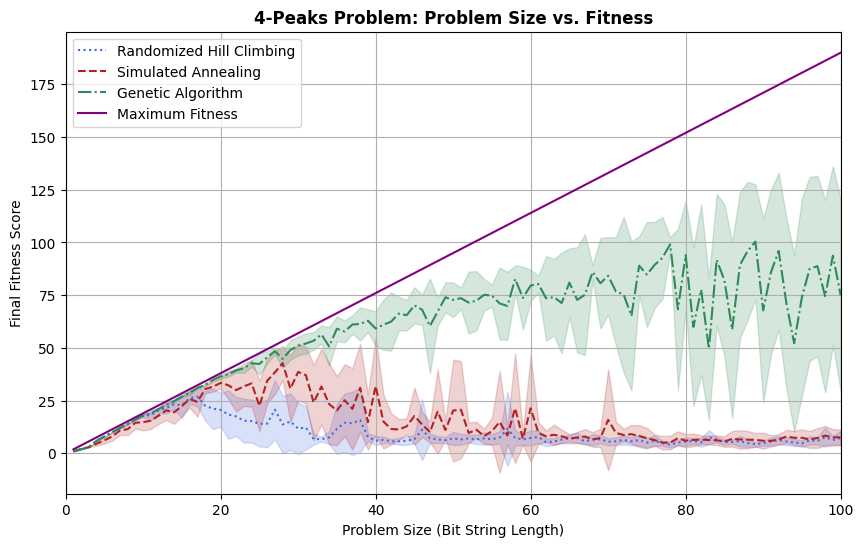

In [ ]:
# Function to run the algorithms and return the final mean and std of fitness values
def run_algorithm_with_final_fitness(problem, algorithm_func, seeds, **kwargs):
    fitness_results = []
    for seed in seeds:
        _, best_fitness, _ = algorithm_func(problem, random_state=seed, curve=True, **kwargs)
        fitness_results.append(best_fitness)

    # Return the mean and standard deviation of the final fitness values across all seeds
    return np.mean(fitness_results), np.std(fitness_results)

# Set multiple seeds for averaging over randomness
seeds = list(range(1, 11))

# Set maximum length
max_length = 100

# Initialize lists to hold the final mean fitness and standard deviation for each algorithm
rhc_fitness_mean = []
rhc_fitness_std = []
sa_fitness_mean = []
sa_fitness_std = []
ga_fitness_mean = []
ga_fitness_std = []
max_fitness_theoretical = []  # List to store the maximum theoretical fitness

# Problem sizes (bit string lengths) to test
problem_sizes = range(1, max_length + 1)  # Bit string lengths from 1 to max_length

# Loop through each problem size and record the final fitness for each algorithm
for size in problem_sizes:
    # Define the fitness function for the 4-peaks problem
    t_pct = 0.10
    fitness = mlrose.FourPeaks(t_pct=t_pct)

    # Define the optimization problem for the current size
    problem = mlrose.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True, max_val=2)

    # Calculate the maximum fitness
    T = t_pct * size
    max_fitness = max(size - T, T) + size  # Maximum fitness = max(n-T,T) + n
    max_fitness_theoretical.append(max_fitness)

    # Run Randomized Hill Climbing and store the final fitness values
    rhc_mean, rhc_std = run_algorithm_with_final_fitness(
        problem, mlrose.random_hill_climb, seeds, max_attempts=10, max_iters=200, restarts=10)
    rhc_fitness_mean.append(rhc_mean)
    rhc_fitness_std.append(rhc_std)

    # Run Simulated Annealing and store the final fitness values
    sa_mean, sa_std = run_algorithm_with_final_fitness(
        problem, mlrose.simulated_annealing, seeds, max_attempts=10, max_iters=200, schedule=mlrose.ExpDecay(init_temp=0.1, exp_const=0.0005, min_temp=0.001))
    sa_fitness_mean.append(sa_mean)
    sa_fitness_std.append(sa_std)

    # Run Genetic Algorithm and store the final fitness values
    ga_mean, ga_std = run_algorithm_with_final_fitness(
        problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=10, max_iters=200)
    ga_fitness_mean.append(ga_mean)
    ga_fitness_std.append(ga_std)

# Plot the problem size vs fitness
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing results
plt.plot(problem_sizes, rhc_fitness_mean, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(problem_sizes,
                 np.array(rhc_fitness_mean) - np.array(rhc_fitness_std),
                 np.array(rhc_fitness_mean) + np.array(rhc_fitness_std),
                 alpha=0.2, color='royalblue')

# Plot Simulated Annealing results
plt.plot(problem_sizes, sa_fitness_mean, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(problem_sizes,
                 np.array(sa_fitness_mean) - np.array(sa_fitness_std),
                 np.array(sa_fitness_mean) + np.array(sa_fitness_std),
                 alpha=0.2, color='firebrick')

# Plot Genetic Algorithm results
plt.plot(problem_sizes, ga_fitness_mean, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(problem_sizes,
                 np.array(ga_fitness_mean) - np.array(ga_fitness_std),
                 np.array(ga_fitness_mean) + np.array(ga_fitness_std),
                 alpha=0.2, color='seagreen')

# Plot the maximum theoretical fitness line
plt.plot(problem_sizes, max_fitness_theoretical, label='Maximum Fitness', linestyle='-', color='purple')

# Add plot title and labels
plt.title('4-Peaks Problem: Problem Size vs. Fitness', fontweight='bold')
plt.xlabel('Problem Size (Bit String Length)')
plt.ylabel('Final Fitness Score')
plt.xlim(0, max_length)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


#### Iteration vs Fitness Plot

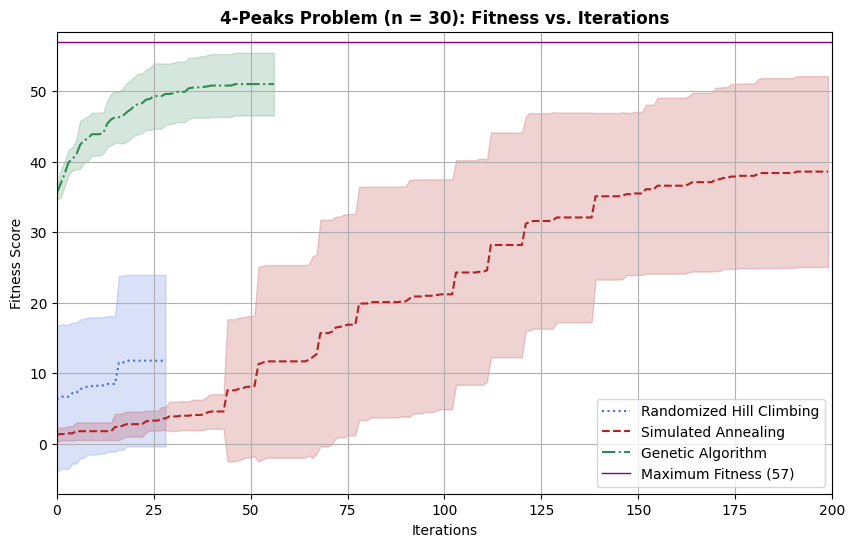

In [ ]:
# Function to run the algorithms and return the final state, mean and std of fitness curves at each iteration
def run_algorithm_with_curve_and_variance(problem, algorithm_func, seeds, **kwargs):
    fitness_curves = []
    final_states = []

    for seed in seeds:
        final_state, _, fitness_curve = algorithm_func(problem, random_state=seed, curve=True, **kwargs)

        # If the fitness_curve has multiple columns, take only the first (fitness) column
        if len(fitness_curve.shape) > 1:  # Check if the curve is multidimensional
            fitness_curve = fitness_curve[:, 0]  # Take only the first column (fitness values)

        fitness_curves.append(fitness_curve)
        final_states.append(final_state)  # Store the final state for this seed

    # Find the maximum number of iterations for all curves
    max_iters = max(len(curve) for curve in fitness_curves)

    # Create arrays to hold the mean and std per iteration
    avg_fitness_curve = np.zeros(max_iters)
    std_fitness_curve = np.zeros(max_iters)

    # For each fitness curve, pad it with its last value to match the longest curve
    for curve in fitness_curves:
        padded_curve = np.pad(curve, (0, max_iters - len(curve)), 'edge')
        avg_fitness_curve += padded_curve

    avg_fitness_curve /= len(seeds)

    # Calculate the mean standard deviation across the seeds
    for i in range(max_iters):
        std_fitness_curve[i] = np.std([np.pad(curve, (0, max_iters - len(curve)), 'edge')[i] for curve in fitness_curves])

    return final_states, avg_fitness_curve, std_fitness_curve




# Define multiple parameters for plot
seeds = list(range(1, 11))    # 10 seeds. Set multiple seeds for averaging over randomness
max_iters = 200    # Maximum iterations
max_attempts = 10  # Maximum attempts
bit_string_length = 30  # Fixed bit string length for this plot
t_pct = 0.1   # Threshold parameter
T = t_pct * bit_string_length

# Define the fitness function for the 4-peaks problem
fitness = mlrose.FourPeaks(t_pct=t_pct)

# Define the optimization problem for the chosen length
problem = mlrose.DiscreteOpt(length=bit_string_length, fitness_fn=fitness, maximize=True, max_val=2)

# Run Randomized Hill Climbing with fitness curve tracking and variance
rhc_final_states, rhc_mean_curve, rhc_std_curve = run_algorithm_with_curve_and_variance(
    problem, mlrose.random_hill_climb, seeds, max_attempts=max_attempts, max_iters=max_iters, restarts=10)

# Run Simulated Annealing with fitness curve tracking and variance
sa_final_states, sa_mean_curve, sa_std_curve = run_algorithm_with_curve_and_variance(
    problem, mlrose.simulated_annealing, seeds, max_attempts=max_attempts, max_iters=max_iters, schedule=mlrose.ExpDecay(init_temp=0.1, exp_const=0.0005, min_temp=0.001))

# Run Genetic Algorithm with fitness curve tracking and variance
ga_final_states, ga_mean_curve, ga_std_curve = run_algorithm_with_curve_and_variance(
    problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=max_attempts, max_iters=max_iters)

# Define iterations based on the length of each fitness curve
rhc_iterations = range(len(rhc_mean_curve))
sa_iterations = range(len(sa_mean_curve))
ga_iterations = range(len(ga_mean_curve))

# Plot the fitness curves at each iteration with variance shading
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing fitness curve with fill_between for variance
plt.plot(rhc_iterations, rhc_mean_curve, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(rhc_iterations, rhc_mean_curve - rhc_std_curve, rhc_mean_curve + rhc_std_curve, alpha=0.2, color='royalblue')

# Plot Simulated Annealing fitness curve with fill_between for variance
plt.plot(sa_iterations, sa_mean_curve, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(sa_iterations, sa_mean_curve - sa_std_curve, sa_mean_curve + sa_std_curve, alpha=0.2, color='firebrick')

# Plot Genetic Algorithm fitness curve with fill_between for variance
plt.plot(ga_iterations, ga_mean_curve, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(ga_iterations, ga_mean_curve - ga_std_curve, ga_mean_curve + ga_std_curve, alpha=0.2, color='seagreen')

# Plot the maximum fitness score line
n = bit_string_length
max_fitness = int(max(n - T, T) + n)
plt.axhline(y=max_fitness, color='purple', linestyle='-', linewidth=1, label=f'Maximum Fitness ({max_fitness})')

# Add plot title and labels
plt.title('4-Peaks Problem (n = 30): Fitness vs. Iterations', fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Fitness Score')
plt.legend()
plt.xlim(0, max_iters)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Report final states for each algorithm
print("Randomized Hill Climbing Final States:")
for i, state in enumerate(rhc_final_states):
    print(f"Seed {seeds[i]}: {state}")

print("\nSimulated Annealing Final States:")
for i, state in enumerate(sa_final_states):
    print(f"Seed {seeds[i]}: {state}")

print("\nGenetic Algorithm Final States:")
for i, state in enumerate(ga_final_states):
    print(f"Seed {seeds[i]}: {state}")

Randomized Hill Climbing Final States:
Seed 1: [1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 1]
Seed 2: [1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0]
Seed 3: [1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1]
Seed 4: [1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1]
Seed 5: [1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0]
Seed 6: [1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0]
Seed 7: [1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 0]
Seed 8: [1 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0]
Seed 9: [0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0]
Seed 10: [1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0]

Simulated Annealing Final States:
Seed 1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0]
Seed 2: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0]
Seed 3: [1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Seed 4: [1 1 1 

#### Function Evaluations per Iteration

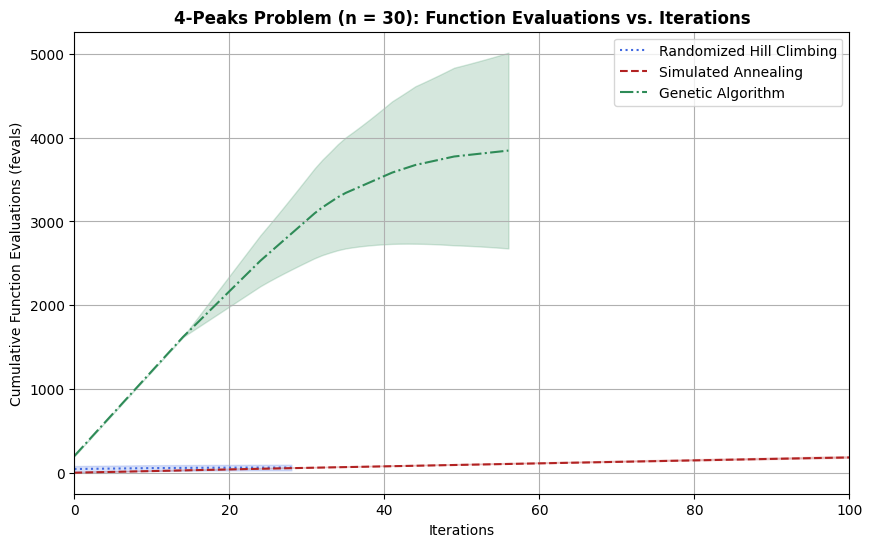

In [ ]:
# Function to run the algorithms and return the final state, mean and std of fevals at each iteration
def run_algorithm_with_fevals(problem, algorithm_func, seeds, **kwargs):
    fevals_curves = []
    final_states = []

    for seed in seeds:
        final_state, _, fitness_curve = algorithm_func(problem, random_state=seed, curve=True, **kwargs)

        # If the fitness_curve has multiple columns, take the second column (function evaluations)
        if len(fitness_curve.shape) > 1:  # Check if the curve is multidimensional
            fevals_curve = fitness_curve[:, 1]  # Take the second column (fevals values)

        fevals_curves.append(fevals_curve)
        final_states.append(final_state)  # Store the final state for this seed

    # Find the maximum number of iterations for all curves
    max_iters = max(len(curve) for curve in fevals_curves)

    # Create arrays to hold the mean and std per iteration
    avg_fevals_curve = np.zeros(max_iters)
    std_fevals_curve = np.zeros(max_iters)

    # For each fevals curve, pad it with its last value to match the longest curve
    for curve in fevals_curves:
        padded_curve = np.pad(curve, (0, max_iters - len(curve)), 'edge')
        avg_fevals_curve += padded_curve

    avg_fevals_curve /= len(seeds)

    # Calculate the mean standard deviation across the seeds
    for i in range(max_iters):
        std_fevals_curve[i] = np.std([np.pad(curve, (0, max_iters - len(curve)), 'edge')[i] for curve in fevals_curves])

    return final_states, avg_fevals_curve, std_fevals_curve

# Define multiple parameters for plot
seeds = list(range(1, 11))    # 10 seeds. Set multiple seeds for averaging over randomness
max_iters = 200    # Maximum iterations
max_attempts = 10  # Maximum attempts
bit_string_length = 30  # Fixed bit string length for this plot
t_pct = 0.1   # Threshold parameter
T = t_pct * bit_string_length

# Define the fitness function for the 4-peaks problem
fitness = mlrose.FourPeaks(t_pct=t_pct)

# Define the optimization problem for the chosen length
problem = mlrose.DiscreteOpt(length=bit_string_length, fitness_fn=fitness, maximize=True, max_val=2)

# Run Randomized Hill Climbing with fevals tracking
rhc_final_states, rhc_mean_fevals, rhc_std_fevals = run_algorithm_with_fevals(
    problem, mlrose.random_hill_climb, seeds, max_attempts=max_attempts, max_iters=max_iters, restarts=10)

# Run Simulated Annealing with fevals tracking
sa_final_states, sa_mean_fevals, sa_std_fevals = run_algorithm_with_fevals(
    problem, mlrose.simulated_annealing, seeds, max_attempts=max_attempts, max_iters=max_iters, schedule=mlrose.ExpDecay(init_temp=0.1, exp_const=0.0005, min_temp=0.001))

# Run Genetic Algorithm with fevals tracking
ga_final_states, ga_mean_fevals, ga_std_fevals = run_algorithm_with_fevals(
    problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=max_attempts, max_iters=max_iters)

# Define iterations based on the length of each fevals curve
rhc_iterations = range(len(rhc_mean_fevals))
sa_iterations = range(len(sa_mean_fevals))
ga_iterations = range(len(ga_mean_fevals))

# Plot the fevals curves at each iteration with variance shading
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing fevals curve with fill_between for variance
plt.plot(rhc_iterations, rhc_mean_fevals, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(rhc_iterations, rhc_mean_fevals - rhc_std_fevals, rhc_mean_fevals + rhc_std_fevals, alpha=0.2, color='royalblue')

# Plot Simulated Annealing fevals curve with fill_between for variance
plt.plot(sa_iterations, sa_mean_fevals, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(sa_iterations, sa_mean_fevals - sa_std_fevals, sa_mean_fevals + sa_std_fevals, alpha=0.2, color='firebrick')

# Plot Genetic Algorithm fevals curve with fill_between for variance
plt.plot(ga_iterations, ga_mean_fevals, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(ga_iterations, ga_mean_fevals - ga_std_fevals, ga_mean_fevals + ga_std_fevals, alpha=0.2, color='seagreen')

# Add plot title and labels
plt.title('4-Peaks Problem (n = 30): Function Evaluations vs. Iterations', fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Function Evaluations (fevals)')
plt.legend()
plt.xlim(0, 100)
plt.grid(True)

# Show the plot
plt.show()


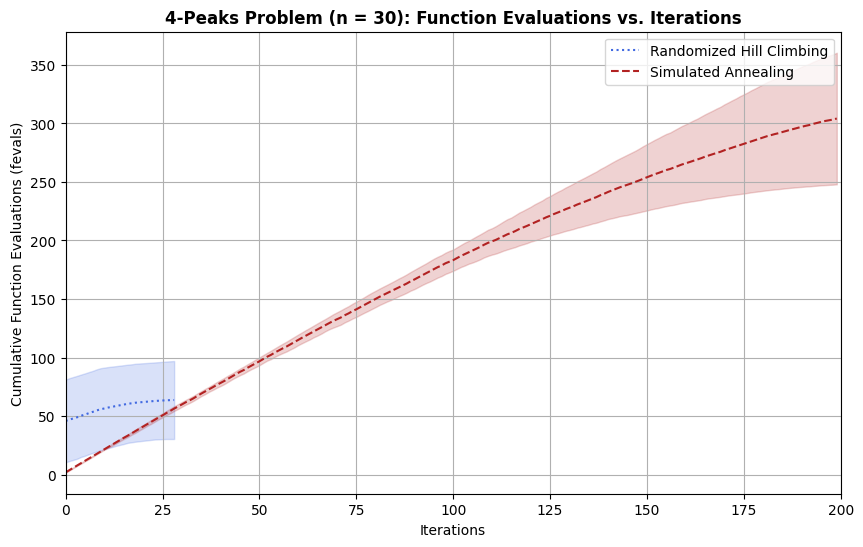

In [ ]:
# Plot the fevals curves at each iteration with variance shading
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing fevals curve with fill_between for variance
plt.plot(rhc_iterations, rhc_mean_fevals, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(rhc_iterations, rhc_mean_fevals - rhc_std_fevals, rhc_mean_fevals + rhc_std_fevals, alpha=0.2, color='royalblue')

# Plot Simulated Annealing fevals curve with fill_between for variance
plt.plot(sa_iterations, sa_mean_fevals, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(sa_iterations, sa_mean_fevals - sa_std_fevals, sa_mean_fevals + sa_std_fevals, alpha=0.2, color='firebrick')

# Add plot title and labels
plt.title('4-Peaks Problem (n = 30): Function Evaluations vs. Iterations', fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Function Evaluations (fevals)')
plt.legend()
plt.xlim(0, max_iters)
plt.grid(True)

# Show the plot
plt.show()

#### Wall Clock Time Plot

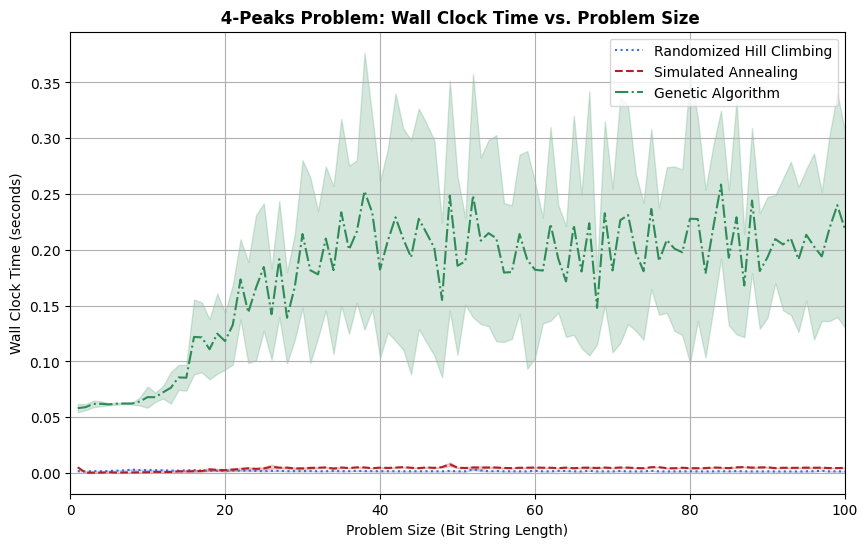

In [ ]:
# Function to run the algorithms and return the wall clock time
def run_algorithm_with_time(problem, algorithm_func, seeds, **kwargs):
    times = []
    for seed in seeds:
        start_time = time.time()  # Start the clock
        algorithm_func(problem, random_state=seed, **kwargs)
        end_time = time.time()  # End the clock
        times.append(end_time - start_time)

    # Return the mean and standard deviation of the times across all seeds
    return np.mean(times), np.std(times)

# Set multiple seeds for averaging over randomness
seeds = list(range(1, 11))  # 10 seeds

# Set maximum length
max_length = 100

# Initialize lists to hold the wall clock time (mean and std) for each algorithm
rhc_time_mean = []
rhc_time_std = []
sa_time_mean = []
sa_time_std = []
ga_time_mean = []
ga_time_std = []

# Problem sizes (bit string lengths) to test for wall clock time
problem_sizes = range(1, max_length + 1)  # Bit string lengths from 1 to max_length

# Loop through each problem size and record the wall clock time for each algorithm
for size in problem_sizes:
    # Define the fitness function for the 4-peaks problem
    fitness = mlrose.FourPeaks(t_pct=0.10)

    # Define the optimization problem for the current size
    problem = mlrose.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True, max_val=2)

    # Run Randomized Hill Climbing and store the wall clock time
    rhc_mean, rhc_std = run_algorithm_with_time(
        problem, mlrose.random_hill_climb, seeds, max_attempts=10, max_iters=200, restarts=10)
    rhc_time_mean.append(rhc_mean)
    rhc_time_std.append(rhc_std)

    # Run Simulated Annealing and store the wall clock time
    sa_mean, sa_std = run_algorithm_with_time(
        problem, mlrose.simulated_annealing, seeds, max_attempts=10, max_iters=200, schedule=mlrose.ExpDecay(init_temp=0.1, exp_const=0.0005, min_temp=0.001))
    sa_time_mean.append(sa_mean)
    sa_time_std.append(sa_std)

    # Run Genetic Algorithm and store the wall clock time
    ga_mean, ga_std = run_algorithm_with_time(
        problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=10, max_iters=200)
    ga_time_mean.append(ga_mean)
    ga_time_std.append(ga_std)

# Plot the problem size vs wall clock time
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing wall clock time
plt.plot(problem_sizes, rhc_time_mean, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(problem_sizes,
                 np.array(rhc_time_mean) - np.array(rhc_time_std),
                 np.array(rhc_time_mean) + np.array(rhc_time_std),
                 alpha=0.2, color='royalblue')

# Plot Simulated Annealing wall clock time
plt.plot(problem_sizes, sa_time_mean, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(problem_sizes,
                 np.array(sa_time_mean) - np.array(sa_time_std),
                 np.array(sa_time_mean) + np.array(sa_time_std),
                 alpha=0.2, color='firebrick')

# Plot Genetic Algorithm wall clock time
plt.plot(problem_sizes, ga_time_mean, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(problem_sizes,
                 np.array(ga_time_mean) - np.array(ga_time_std),
                 np.array(ga_time_mean) + np.array(ga_time_std),
                 alpha=0.2, color='seagreen')

# Add plot title and labels
plt.title(' 4-Peaks Problem: Wall Clock Time vs. Problem Size', fontweight='bold')
plt.xlabel('Problem Size (Bit String Length)')
plt.ylabel('Wall Clock Time (seconds)')
plt.xlim(0, max_length)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


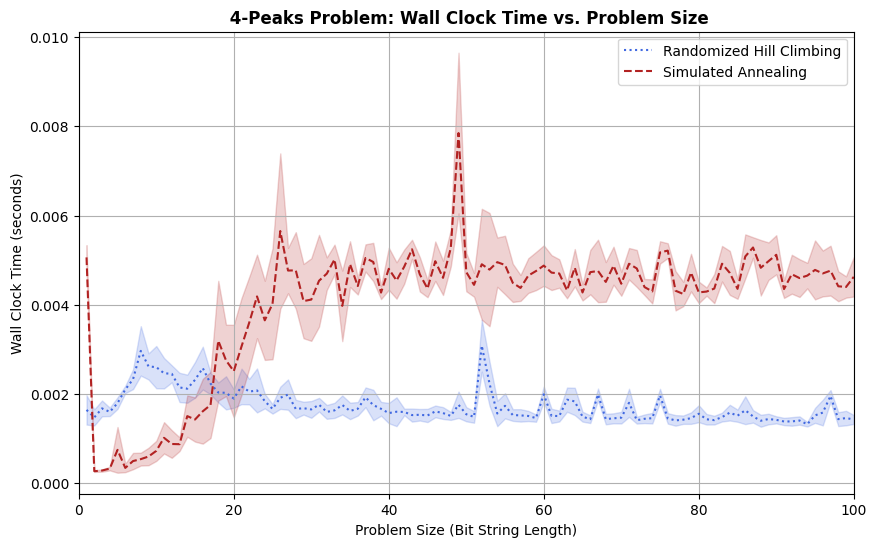

In [ ]:
# Plot the problem size vs wall clock time
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing wall clock time
plt.plot(problem_sizes, rhc_time_mean, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(problem_sizes,
                 np.array(rhc_time_mean) - np.array(rhc_time_std),
                 np.array(rhc_time_mean) + np.array(rhc_time_std),
                 alpha=0.2, color='royalblue')

# Plot Simulated Annealing wall clock time
plt.plot(problem_sizes, sa_time_mean, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(problem_sizes,
                 np.array(sa_time_mean) - np.array(sa_time_std),
                 np.array(sa_time_mean) + np.array(sa_time_std),
                 alpha=0.2, color='firebrick')



# Add plot title and labels
plt.title(' 4-Peaks Problem: Wall Clock Time vs. Problem Size', fontweight='bold')
plt.xlabel('Problem Size (Bit String Length)')
plt.ylabel('Wall Clock Time (seconds)')
plt.xlim(0, max_length)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


#### References and Tests

In [ ]:
# Fitness function for 4-peaks optimization problem
# Reference: https://mlrose.readthedocs.io/en/stable/source/fitness.html?highlight=peak
fitness = mlrose.FourPeaks(t_pct=0.10)  # t_pct defines the threshold parameter (T = t_pct x n)


# Define the optimization problem as discrete-state
# Reference: https://mlrose.readthedocs.io/en/stable/source/opt_probs.html?highlight=discreteOpt#mlrose.opt_probs.DiscreteOpt
problem = mlrose.DiscreteOpt(length=20, fitness_fn=fitness, maximize=True, max_val= 2)   # Only 2 unique values (0 and 1)


### IMPLEMENT ALGORITHMS ###
# Reference: https://mlrose.readthedocs.io/en/stable/source/algorithms.html?highlight=random_hill_climbing

# Randomized Hill Climbing algorithm
rhc_best_state, rhc_best_fitness, rhc_fitness_curve = mlrose.random_hill_climb(problem,
                                                                               max_attempts=100, max_iters=100, restarts=10, curve=True, random_state=seed)
print("Randomized Hill Climbing best state:", rhc_best_state)
print("Randomized Hill Climbing best fitness:", rhc_best_fitness)
print()


# Simulated Annealing algorithm
schedule = mlrose.ExpDecay()  # Schedule for temperature parameter. Other options include GeomDecay & ArithDecay
# Reference: https://mlrose.readthedocs.io/en/stable/source/decay.html
sa_best_state, sa_best_fitness, sa_fitness_curve = mlrose.simulated_annealing(problem,
                                                                              schedule=schedule, max_attempts=100, max_iters=100, curve=True, random_state=seed)
print("Simulated Annealing best state:", sa_best_state)
print("Simulated Annealing best fitness:", sa_best_fitness)
print()


# Genetic Algorithm
ga_best_state, ga_best_fitness, ga_fitness_curve = mlrose.genetic_alg(problem,
                                                                      pop_size=100, mutation_prob=0.1, max_attempts=100, max_iters=100, curve=True, random_state= seed)
print("Genetic Algorithm best state:", ga_best_state)
print("Genetic Algorithm best fitness:", ga_best_fitness)
print()


## TEST FITNESS EVALUATION
fitness = mlrose.FourPeaks(t_pct=0.15)
state = np.array([1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0])
print(fitness.evaluate(state))

state = np.array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1])
print(fitness.evaluate(state))

Randomized Hill Climbing best state: [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Randomized Hill Climbing best fitness: 37.0

Simulated Annealing best state: [0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0]
Simulated Annealing best fitness: 1.0

Genetic Algorithm best state: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
Genetic Algorithm best fitness: 37.0

16
0


### Part 1.2: Max k-Color Problem

#### Max K-Color to Solve

In [ ]:
# Function to plot colored node maps
def plot_max_kcolor_graph(edges, state, seed=seed):
    """
    Plot a graph with nodes colored according to their state, and edges
    colored green if there's no conflict, or black if there's a conflict.

    Parameters:
    - edges: list of tuples representing the graph edges (connections between nodes)
    - state: numpy array representing the colors assigned to each node
    - seed: random seed for spring layout positioning (default is 42)
    """
    # Create the graph
    G = nx.Graph()
    G.add_edges_from(edges)

    # Define the colors (translate 0 to 'red', 1 to 'blue', etc.)
    color_map = ['red' if color == 0 else 'blue' for color in state]

    # Define edge colors: green for no conflict, black for conflict
    edge_colors = []
    for edge in edges:
        node1, node2 = edge
        if state[node1] != state[node2]:  # No conflict
            edge_colors.append('green')
        else:  # Conflict
            edge_colors.append('black')

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=seed)  # Use spring layout for positioning nodes
    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=400,
            font_size=8, font_color='white', edge_color=edge_colors,
            linewidths=2, width=2, font_weight='bold')

    # Show the plot
    plt.title("Graph Visualization with Max K-Coloring\n(Green Edges = No Conflict)", fontweight='bold')
    plt.show()

In [ ]:
# Function to plot node maps with all nodes in purple and all edges in black
def plot_node_graph(edges, seed=seed):
    """
    Plot a graph with all nodes colored purple and all edges black.

    Parameters:
    - edges: list of tuples representing the graph edges (connections between nodes)
    - seed: random seed for spring layout positioning
    """
    # Create the graph
    G = nx.Graph()
    G.add_edges_from(edges)

    # Define node color (all nodes purple)
    color_map = ['purple'] * len(G.nodes)

    # Define edge colors (all edges black)
    edge_colors = ['black'] * len(G.edges)

    # Draw the graph
    plt.figure(figsize=(12, 8))  # Use consistent figure size
    pos = nx.spring_layout(G, seed=seed)  # Use spring layout for positioning nodes
    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=400,  # All nodes are purple
            font_size=8, font_color='white', edge_color=edge_colors,  # All edges are black
            linewidths=2, width=2, font_weight='bold')

    # Show the plot
    plt.title("Graph Visualization with All Nodes in Purple", fontweight='bold')
    plt.show()



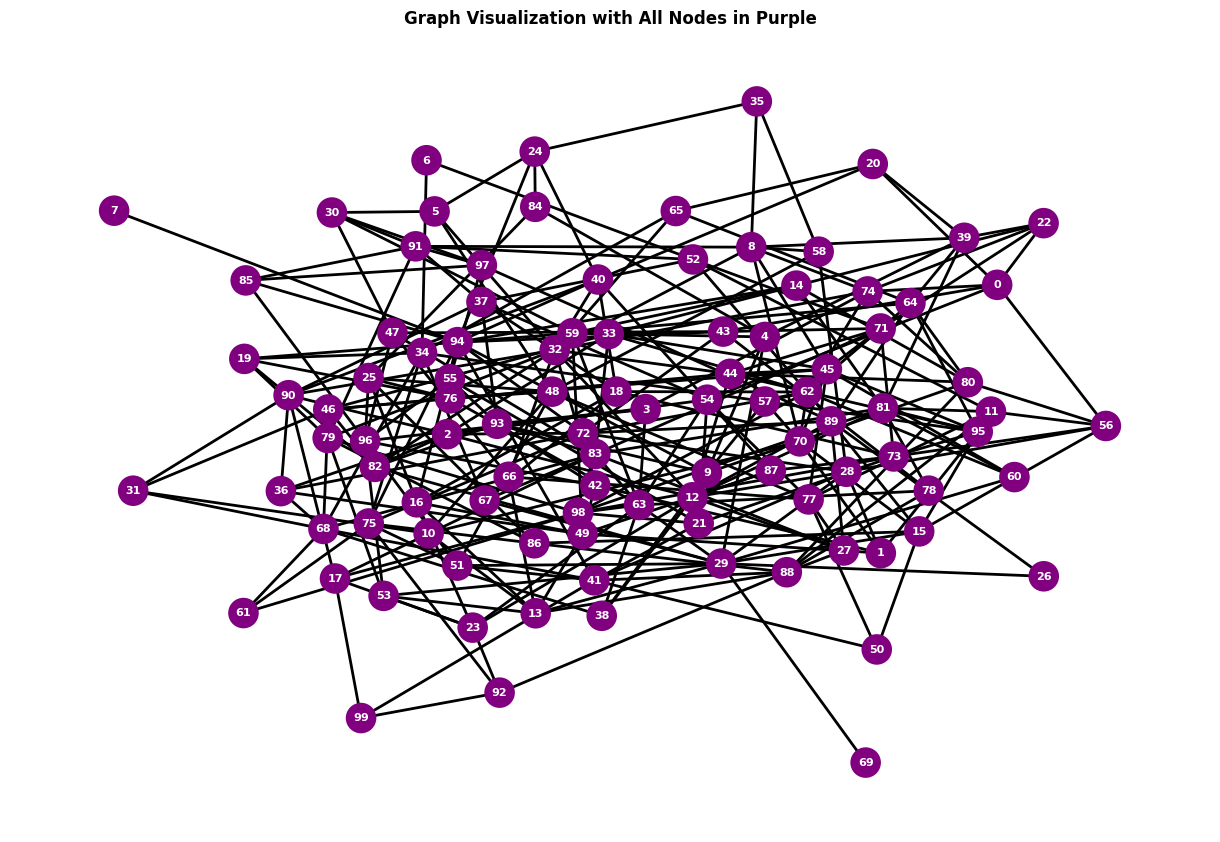

Number of edges: 300


In [ ]:
problem = mlrose.MaxKColorGenerator().generate(seed= 5, number_of_nodes=100, max_connections_per_node=5, max_colors=2, maximize = True)

# Plot graph
plot_node_graph(problem.source_graph.edges)

print("Number of edges:", problem.source_graph.number_of_edges() )

#### Problem Size vs Fitness Plot

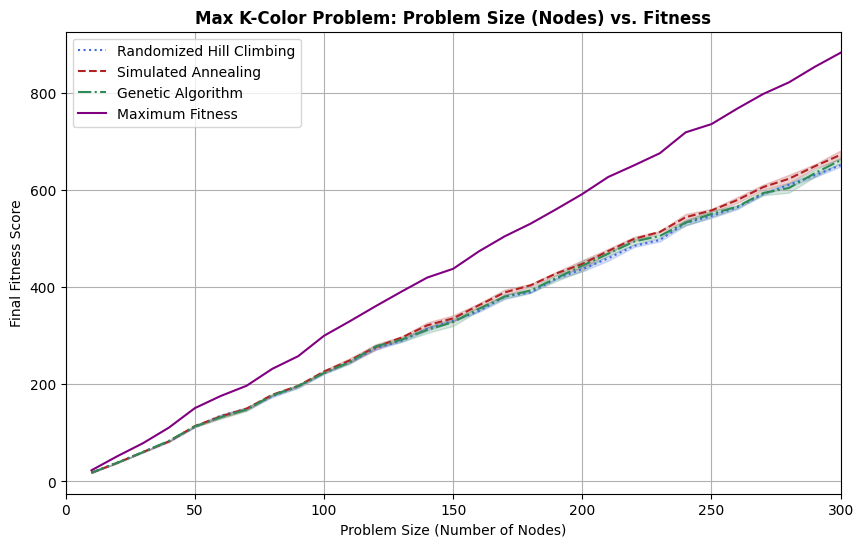

In [ ]:
# Function to run the algorithms and return the final mean and std of fitness values
def run_algorithm_with_final_fitness(problem, algorithm_func, seeds, **kwargs):
    fitness_results = []
    for seed in seeds:
        _, best_fitness, _ = algorithm_func(problem, random_state=seed, curve=True, **kwargs)
        fitness_results.append(best_fitness)

    # Return the mean and standard deviation of the final fitness values across all seeds
    return np.mean(fitness_results), np.std(fitness_results)

# Set multiple seeds for averaging over randomness
seeds = list(range(1, 6))  # Using 5 seeds

# Set maximum number of nodes for the problem
max_nodes = 300

# Initialize lists to hold the final mean fitness and standard deviation for each algorithm
rhc_fitness_mean = []
rhc_fitness_std = []
sa_fitness_mean = []
sa_fitness_std = []
ga_fitness_mean = []
ga_fitness_std = []
max_fitness_theoretical = []  # List to store the maximum theoretical fitness for each graph

# Problem sizes (number of nodes in the graph) to test
problem_sizes = range(10, max_nodes + 1, 10)  # Test for graphs with 10, 20, ..., 100 nodes

# Loop through each problem size and record the final fitness for each algorithm
for num_nodes in problem_sizes:
    # Define the Max K-Color problem for the current size
    problem = mlrose.MaxKColorGenerator().generate(seed=5, number_of_nodes=num_nodes, max_connections_per_node=5, max_colors=2, maximize=True)

    # Calculate the maximum fitness based on the number of edges in the graph
    max_fitness = problem.source_graph.number_of_edges()  # Maximum fitness is the number of edges (no conflicts)
    max_fitness_theoretical.append(max_fitness)

    # Run Randomized Hill Climbing and store the final fitness values
    rhc_mean, rhc_std = run_algorithm_with_final_fitness(
        problem, mlrose.random_hill_climb, seeds, max_attempts=100, max_iters=3000, restarts=10)
    rhc_fitness_mean.append(rhc_mean)
    rhc_fitness_std.append(rhc_std)

    # Run Simulated Annealing and store the final fitness values
    sa_mean, sa_std = run_algorithm_with_final_fitness(
        problem, mlrose.simulated_annealing, seeds, max_attempts=100, max_iters=3000, schedule=mlrose.ExpDecay(init_temp=200, exp_const=0.01, min_temp=0.00001))
        # problem, mlrose.simulated_annealing, seeds, max_attempts=10, max_iters=1500, schedule=mlrose.ExpDecay(init_temp=200, exp_const=0.01, min_temp=0.00001))
          # problem, mlrose.simulated_annealing, seeds, max_attempts=10, max_iters=5000, schedule=mlrose.ExpDecay(init_temp=200, exp_const=0.01, min_temp=0.00001))

    sa_fitness_mean.append(sa_mean)
    sa_fitness_std.append(sa_std)

    # Run Genetic Algorithm and store the final fitness values
    ga_mean, ga_std = run_algorithm_with_final_fitness(
        problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=100, max_iters=3000)
    ga_fitness_mean.append(ga_mean)
    ga_fitness_std.append(ga_std)

# Plot the problem size vs fitness
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing results
plt.plot(problem_sizes, rhc_fitness_mean, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(problem_sizes,
                 np.array(rhc_fitness_mean) - np.array(rhc_fitness_std),
                 np.array(rhc_fitness_mean) + np.array(rhc_fitness_std),
                 alpha=0.2, color='royalblue')

# Plot Simulated Annealing results
plt.plot(problem_sizes, sa_fitness_mean, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(problem_sizes,
                 np.array(sa_fitness_mean) - np.array(sa_fitness_std),
                 np.array(sa_fitness_mean) + np.array(sa_fitness_std),
                 alpha=0.2, color='firebrick')

# Plot Genetic Algorithm results
plt.plot(problem_sizes, ga_fitness_mean, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(problem_sizes,
                 np.array(ga_fitness_mean) - np.array(ga_fitness_std),
                 np.array(ga_fitness_mean) + np.array(ga_fitness_std),
                 alpha=0.2, color='seagreen')

# Plot the maximum theoretical fitness line
plt.plot(problem_sizes, max_fitness_theoretical, label='Maximum Fitness', linestyle='-', color='purple')

# Add plot title and labels
plt.title('Max K-Color Problem: Problem Size (Nodes) vs. Fitness', fontweight='bold')
plt.xlabel('Problem Size (Number of Nodes)')
plt.ylabel('Final Fitness Score')
plt.xlim(0, max_nodes)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


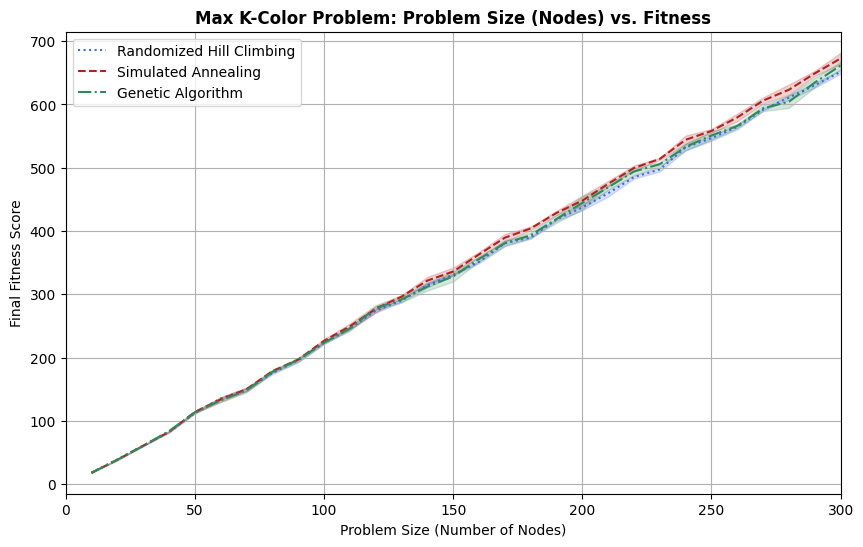

In [ ]:
# Plot the problem size vs fitness
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing results
plt.plot(problem_sizes, rhc_fitness_mean, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(problem_sizes,
                 np.array(rhc_fitness_mean) - np.array(rhc_fitness_std),
                 np.array(rhc_fitness_mean) + np.array(rhc_fitness_std),
                 alpha=0.2, color='royalblue')

# Plot Simulated Annealing results
plt.plot(problem_sizes, sa_fitness_mean, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(problem_sizes,
                 np.array(sa_fitness_mean) - np.array(sa_fitness_std),
                 np.array(sa_fitness_mean) + np.array(sa_fitness_std),
                 alpha=0.2, color='firebrick')

# Plot Genetic Algorithm results
plt.plot(problem_sizes, ga_fitness_mean, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(problem_sizes,
                 np.array(ga_fitness_mean) - np.array(ga_fitness_std),
                 np.array(ga_fitness_mean) + np.array(ga_fitness_std),
                 alpha=0.2, color='seagreen')

# # Plot the maximum theoretical fitness line
# plt.plot(problem_sizes, max_fitness_theoretical, label='Maximum Fitness', linestyle='-', color='purple')

# Add plot title and labels
plt.title('Max K-Color Problem: Problem Size (Nodes) vs. Fitness', fontweight='bold')
plt.xlabel('Problem Size (Number of Nodes)')
plt.ylabel('Final Fitness Score')
plt.xlim(0, max_nodes)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Iteration vs Fitness Plot

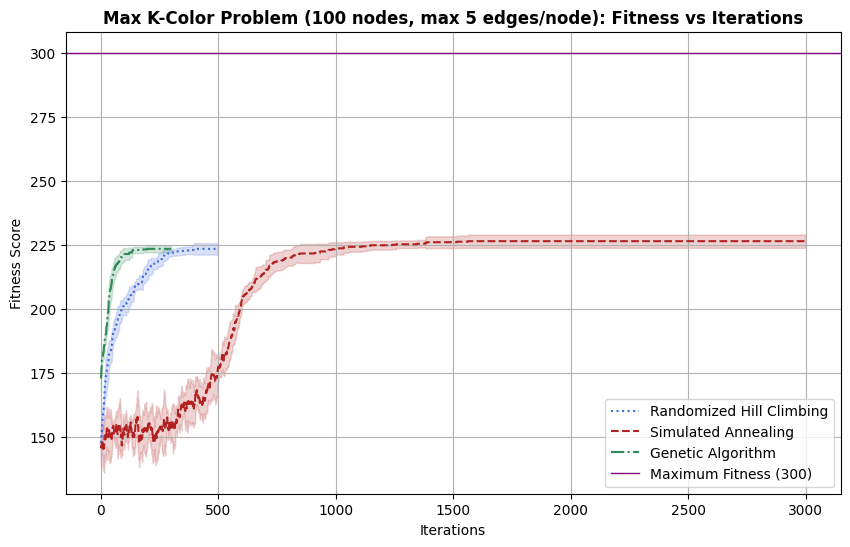

In [ ]:
# Function to run the algorithms and return the final state, mean, and std of fitness curves at each iteration
def run_algorithm_with_curve_and_variance(problem, algorithm_func, seeds, **kwargs):
    fitness_curves = []
    final_states = []
    final_fitnesses = []  # List to store final fitnesses

    for seed in seeds:
        final_state, final_fitness, fitness_curve = algorithm_func(problem, random_state=seed, curve=True, **kwargs)

        # If the fitness_curve has multiple columns, take only the first (fitness) column
        if len(fitness_curve.shape) > 1:  # Check if the curve is multidimensional
            fitness_curve = fitness_curve[:, 0]  # Take only the first column (fitness values)

        fitness_curves.append(fitness_curve)
        final_states.append(final_state)  # Store the final state for this seed
        final_fitnesses.append(final_fitness)  # Store the final fitness for this seed

    # Find the maximum number of iterations for all curves
    max_iters = max(len(curve) for curve in fitness_curves)

    # Create arrays to hold the mean and std per iteration
    avg_fitness_curve = np.zeros(max_iters)
    std_fitness_curve = np.zeros(max_iters)

    # For each fitness curve, pad it with its last value to match the longest curve
    for curve in fitness_curves:
        padded_curve = np.pad(curve, (0, max_iters - len(curve)), 'edge')
        avg_fitness_curve += padded_curve

    avg_fitness_curve /= len(seeds)

    # Calculate the mean standard deviation across the seeds
    for i in range(max_iters):
        std_fitness_curve[i] = np.std([np.pad(curve, (0, max_iters - len(curve)), 'edge')[i] for curve in fitness_curves])

    # Return final states, fitnesses, and the mean and std fitness curves
    return final_states, final_fitnesses, avg_fitness_curve, std_fitness_curve


# Set up parameters for the experiments
seeds = list(range(1, 6))  # 5 seeds for randomness
max_iters = 3000  # Maximum iterations
max_attempts = 100  # Maximum attempts

# Generate a single Max K-Color problem instance with the given specifications
problem = mlrose.MaxKColorGenerator().generate(seed = 5, number_of_nodes=100, max_connections_per_node=5, max_colors=2, maximize=True)

# Calculate the maximum possible fitness based on the number of edges in the graph
max_fitness = problem.source_graph.number_of_edges()  # Max fitness = number of edges (no conflicts)

# Run Randomized Hill Climbing
rhc_final_states, rhc_final_fitnesses, rhc_mean_curve, rhc_std_curve = run_algorithm_with_curve_and_variance(
    problem, mlrose.random_hill_climb, seeds, max_attempts=max_attempts, max_iters=max_iters, restarts=10)

# Run Simulated Annealing
sa_final_states, sa_final_fitnesses, sa_mean_curve, sa_std_curve = run_algorithm_with_curve_and_variance(
    # problem, mlrose.simulated_annealing, seeds, max_attempts=max_attempts, max_iters=max_iters, schedule=mlrose.ExpDecay(init_temp=100, exp_const=0.005, min_temp=0.0001))
    problem, mlrose.simulated_annealing, seeds, max_attempts=max_attempts, max_iters=max_iters, schedule=mlrose.ExpDecay(init_temp=200, exp_const=0.01, min_temp=0.00001))


# Run Genetic Algorithm
ga_final_states, ga_final_fitnesses, ga_mean_curve, ga_std_curve = run_algorithm_with_curve_and_variance(
    problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=max_attempts, max_iters=max_iters)

# Plot the results for the single instance
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing fitness curve
plt.plot(range(len(rhc_mean_curve)), rhc_mean_curve, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(range(len(rhc_mean_curve)), rhc_mean_curve - rhc_std_curve, rhc_mean_curve + rhc_std_curve, alpha=0.2, color='royalblue')

# Plot Simulated Annealing fitness curve
plt.plot(range(len(sa_mean_curve)), sa_mean_curve, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(range(len(sa_mean_curve)), sa_mean_curve - sa_std_curve, sa_mean_curve + sa_std_curve, alpha=0.2, color='firebrick')

# Plot Genetic Algorithm fitness curve
plt.plot(range(len(ga_mean_curve)), ga_mean_curve, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(range(len(ga_mean_curve)), ga_mean_curve - ga_std_curve, ga_mean_curve + ga_std_curve, alpha=0.2, color='seagreen')

# Plot the maximum fitness score as a purple line
plt.axhline(y=max_fitness, color='purple', linestyle='-', linewidth=1, label=f'Maximum Fitness ({max_fitness})')

# Add plot title and labels
plt.title('Max K-Color Problem (100 nodes, max 5 edges/node): Fitness vs Iterations', fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Fitness Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Report last state and fitness for each algorithm
print("Randomized Hill Climbing Final States and Fitnesses:")
print("Fitness:", rhc_final_fitnesses)
for i, (state, fitness) in enumerate(zip(rhc_final_states, rhc_final_fitnesses)):
    print(f"Seed {seeds[i]}: State = {state}")
    # print("Fitness =", fitness)

print("\nSimulated Annealing Final States and Fitnesses:")
print("Fitness:", sa_final_fitnesses)
for i, (state, fitness) in enumerate(zip(sa_final_states, sa_final_fitnesses)):
    print(f"Seed {seeds[i]}: State = {state}")
    # print("Fitness =", fitness)


print("\nGenetic Algorithm Final States and Fitnesses:")
print("Fitness:", ga_final_fitnesses)
for i, (state, fitness) in enumerate(zip(ga_final_states, ga_final_fitnesses)):
    print(f"Seed {seeds[i]}: State = {state}")
    # print("Fitness =", fitness)


Randomized Hill Climbing Final States and Fitnesses:
Fitness: [227.0, 220.0, 224.0, 223.0, 223.0]
Seed 1: State = [1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0
 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 0 0]
Seed 2: State = [0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 0
 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0
 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 1]
Seed 3: State = [1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 1
 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1]
Seed 4: State = [1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0]
Seed 5: State = [0 1 0

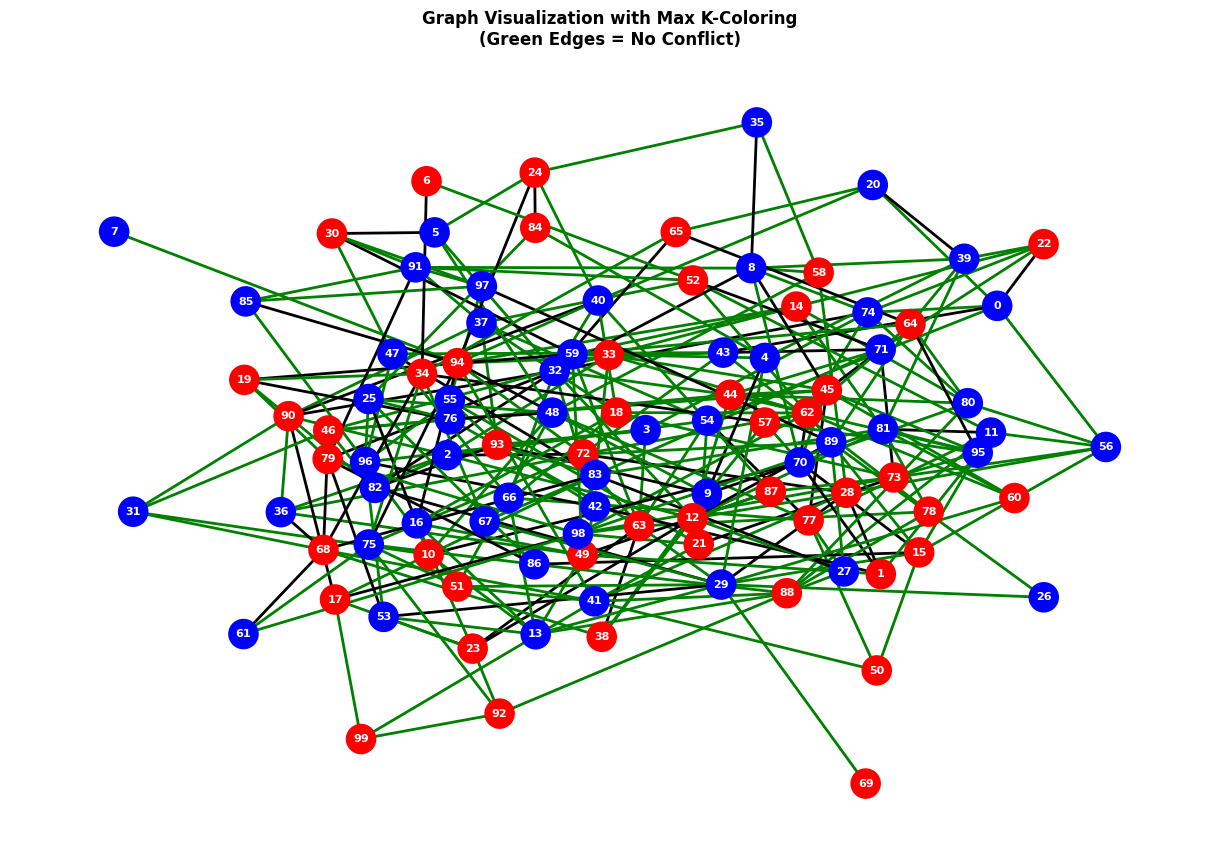

[229.0, 224.0, 225.0, 230.0, 224.0]


In [ ]:
specific_seed = 0
plot_max_kcolor_graph(problem.source_graph.edges, sa_final_states[specific_seed])
print(sa_final_fitnesses)

#### Function Evaluation per Iteration

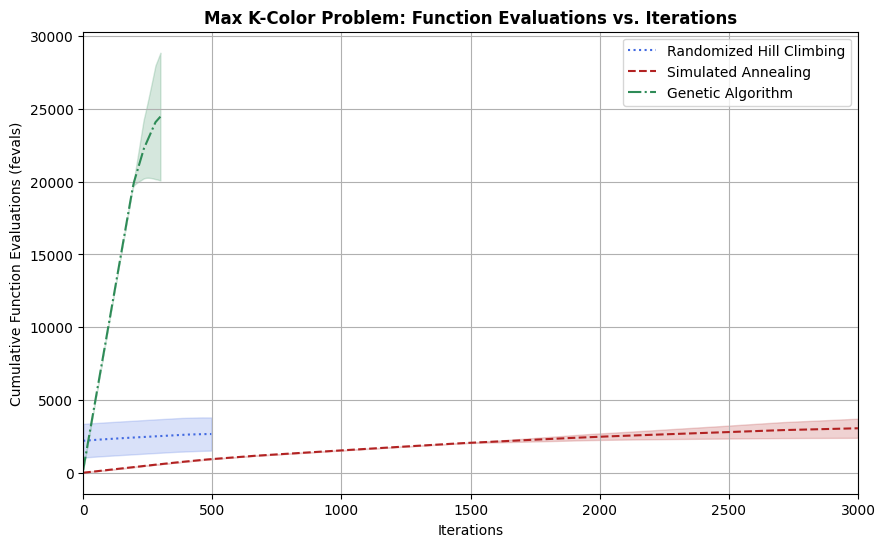

In [ ]:
# Function to run the algorithms and return the final state, mean and std of function evaluations at each iteration
def run_algorithm_with_fevals(problem, algorithm_func, seeds, **kwargs):
    fevals_curves = []
    final_states = []

    for seed in seeds:
        final_state, _, fitness_curve = algorithm_func(problem, random_state=seed, curve=True, **kwargs)

        # If the fitness_curve has multiple columns, take the second column (function evaluations)
        if len(fitness_curve.shape) > 1:  # Check if the curve is multidimensional
            fevals_curve = fitness_curve[:, 1]  # Take the second column (fevals values)

        fevals_curves.append(fevals_curve)
        final_states.append(final_state)  # Store the final state for this seed

    # Find the maximum number of iterations for all curves
    max_iters = max(len(curve) for curve in fevals_curves)

    # Create arrays to hold the mean and std per iteration
    avg_fevals_curve = np.zeros(max_iters)
    std_fevals_curve = np.zeros(max_iters)

    # For each fevals curve, pad it with its last value to match the longest curve
    for curve in fevals_curves:
        padded_curve = np.pad(curve, (0, max_iters - len(curve)), 'edge')
        avg_fevals_curve += padded_curve

    avg_fevals_curve /= len(seeds)

    # Calculate the mean standard deviation across the seeds
    for i in range(max_iters):
        std_fevals_curve[i] = np.std([np.pad(curve, (0, max_iters - len(curve)), 'edge')[i] for curve in fevals_curves])

    return final_states, avg_fevals_curve, std_fevals_curve


# Define multiple parameters for plot
seeds = list(range(1, 6))  # 5 seeds
max_iters = 3000  # Maximum iterations
max_attempts = 100  # Maximum attempts

# Generate a Max K-Color problem instance with 100 nodes
problem = mlrose.MaxKColorGenerator().generate(seed=5, number_of_nodes=100, max_connections_per_node=5, max_colors=2, maximize=True)

# Run Randomized Hill Climbing with fevals tracking
rhc_final_states, rhc_mean_fevals, rhc_std_fevals = run_algorithm_with_fevals(
    problem, mlrose.random_hill_climb, seeds, max_attempts=max_attempts, max_iters=max_iters, restarts=10)

# Run Simulated Annealing with fevals tracking
sa_final_states, sa_mean_fevals, sa_std_fevals = run_algorithm_with_fevals(
    problem, mlrose.simulated_annealing, seeds, max_attempts=max_attempts, max_iters=max_iters, schedule=mlrose.ExpDecay(init_temp=200, exp_const=0.01, min_temp=0.00001))

# Run Genetic Algorithm with fevals tracking
ga_final_states, ga_mean_fevals, ga_std_fevals = run_algorithm_with_fevals(
    problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=max_attempts, max_iters=max_iters)

# Define iterations based on the length of each fevals curve
rhc_iterations = range(len(rhc_mean_fevals))
sa_iterations = range(len(sa_mean_fevals))
ga_iterations = range(len(ga_mean_fevals))

# Plot the function evaluations curves at each iteration with variance shading
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing fevals curve with fill_between for variance
plt.plot(rhc_iterations, rhc_mean_fevals, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(rhc_iterations, rhc_mean_fevals - rhc_std_fevals, rhc_mean_fevals + rhc_std_fevals, alpha=0.2, color='royalblue')

# Plot Simulated Annealing fevals curve with fill_between for variance
plt.plot(sa_iterations, sa_mean_fevals, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(sa_iterations, sa_mean_fevals - sa_std_fevals, sa_mean_fevals + sa_std_fevals, alpha=0.2, color='firebrick')

# Plot Genetic Algorithm fevals curve with fill_between for variance
plt.plot(ga_iterations, ga_mean_fevals, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(ga_iterations, ga_mean_fevals - ga_std_fevals, ga_mean_fevals + ga_std_fevals, alpha=0.2, color='seagreen')

# Add plot title and labels
plt.title('Max K-Color Problem: Function Evaluations vs. Iterations', fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Function Evaluations (fevals)')
plt.legend()
plt.xlim(0, max_iters)
plt.grid(True)

# Show the plot
plt.show()


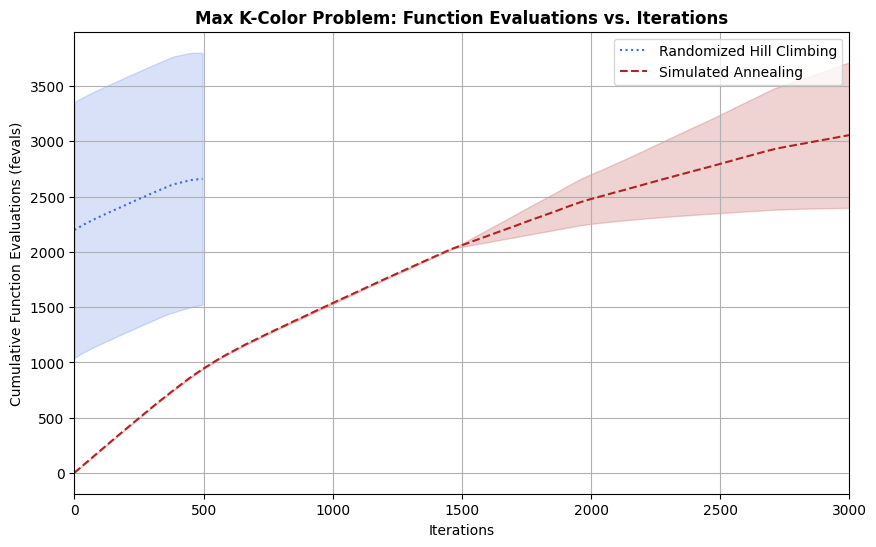

In [ ]:
# Plot the function evaluations curves at each iteration with variance shading
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing fevals curve with fill_between for variance
plt.plot(rhc_iterations, rhc_mean_fevals, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(rhc_iterations, rhc_mean_fevals - rhc_std_fevals, rhc_mean_fevals + rhc_std_fevals, alpha=0.2, color='royalblue')

# Plot Simulated Annealing fevals curve with fill_between for variance
plt.plot(sa_iterations, sa_mean_fevals, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(sa_iterations, sa_mean_fevals - sa_std_fevals, sa_mean_fevals + sa_std_fevals, alpha=0.2, color='firebrick')

# Add plot title and labels
plt.title('Max K-Color Problem: Function Evaluations vs. Iterations', fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Cumulative Function Evaluations (fevals)')
plt.legend()
plt.xlim(0, max_iters)
plt.grid(True)

# Show the plot
plt.show()

#### Wall Clock Time Plot

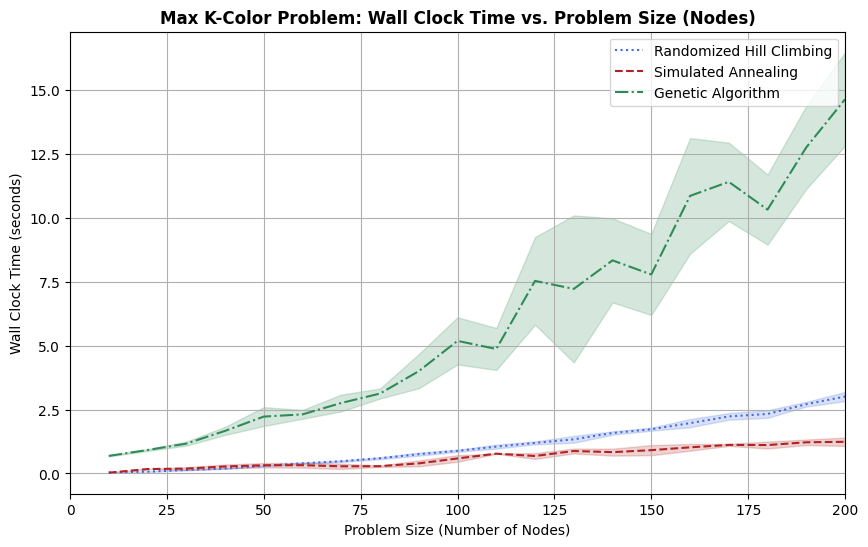

In [ ]:
# Function to run the algorithms and return the wall clock time
def run_algorithm_with_time(problem, algorithm_func, seeds, **kwargs):
    times = []
    for seed in seeds:
        start_time = time.time()  # Start the clock
        algorithm_func(problem, random_state=seed, **kwargs)
        end_time = time.time()  # End the clock
        times.append(end_time - start_time)

    # Return the mean and standard deviation of the times across all seeds
    return np.mean(times), np.std(times)

# Set multiple seeds for averaging over randomness
seeds = list(range(1, 6))  # 5 seeds for randomness

# Set maximum number of nodes for the problem
max_nodes = 200

# Initialize lists to hold the wall clock time (mean and std) for each algorithm
rhc_time_mean = []
rhc_time_std = []
sa_time_mean = []
sa_time_std = []
ga_time_mean = []
ga_time_std = []

# Problem sizes (number of nodes in the graph) to test
problem_sizes = range(10, max_nodes + 1, 10)  # Test for graphs with 10, 20, ..., 200 nodes

# Loop through each problem size and record the wall clock time for each algorithm
for num_nodes in problem_sizes:
    # Define the Max K-Color problem for the current size
    problem = mlrose.MaxKColorGenerator().generate(seed=5, number_of_nodes=num_nodes, max_connections_per_node=5, max_colors=2, maximize=True)

    # Run Randomized Hill Climbing and store the wall clock time
    rhc_mean, rhc_std = run_algorithm_with_time(
        problem, mlrose.random_hill_climb, seeds, max_attempts=100, max_iters=3000, restarts=10)
    rhc_time_mean.append(rhc_mean)
    rhc_time_std.append(rhc_std)

    # Run Simulated Annealing and store the wall clock time
    sa_mean, sa_std = run_algorithm_with_time(
        problem, mlrose.simulated_annealing, seeds, max_attempts=100, max_iters=3000, schedule=mlrose.ExpDecay(init_temp=200, exp_const=0.01, min_temp=0.00001))
    sa_time_mean.append(sa_mean)
    sa_time_std.append(sa_std)

    # Run Genetic Algorithm and store the wall clock time
    ga_mean, ga_std = run_algorithm_with_time(
        problem, mlrose.genetic_alg, seeds, pop_size=100, mutation_prob=0.1, max_attempts=100, max_iters=3000)
    ga_time_mean.append(ga_mean)
    ga_time_std.append(ga_std)

# Plot the problem size vs wall clock time
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing wall clock time
plt.plot(problem_sizes, rhc_time_mean, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(problem_sizes,
                 np.array(rhc_time_mean) - np.array(rhc_time_std),
                 np.array(rhc_time_mean) + np.array(rhc_time_std),
                 alpha=0.2, color='royalblue')

# Plot Simulated Annealing wall clock time
plt.plot(problem_sizes, sa_time_mean, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(problem_sizes,
                 np.array(sa_time_mean) - np.array(sa_time_std),
                 np.array(sa_time_mean) + np.array(sa_time_std),
                 alpha=0.2, color='firebrick')

# Plot Genetic Algorithm wall clock time
plt.plot(problem_sizes, ga_time_mean, label='Genetic Algorithm', linestyle='-.', color='seagreen')
plt.fill_between(problem_sizes,
                 np.array(ga_time_mean) - np.array(ga_time_std),
                 np.array(ga_time_mean) + np.array(ga_time_std),
                 alpha=0.2, color='seagreen')

# Add plot title and labels
plt.title('Max K-Color Problem: Wall Clock Time vs. Problem Size (Nodes)', fontweight='bold')
plt.xlabel('Problem Size (Number of Nodes)')
plt.ylabel('Wall Clock Time (seconds)')
plt.xlim(0, max_nodes)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


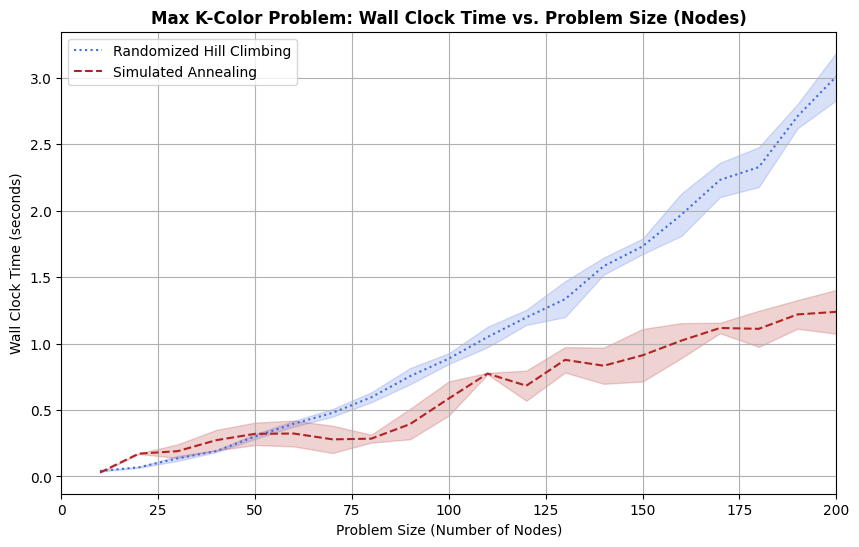

In [ ]:
# Plot the problem size vs wall clock time
plt.figure(figsize=(10, 6))

# Plot Randomized Hill Climbing wall clock time
plt.plot(problem_sizes, rhc_time_mean, label='Randomized Hill Climbing', linestyle=':', color='royalblue')
plt.fill_between(problem_sizes,
                 np.array(rhc_time_mean) - np.array(rhc_time_std),
                 np.array(rhc_time_mean) + np.array(rhc_time_std),
                 alpha=0.2, color='royalblue')

# Plot Simulated Annealing wall clock time
plt.plot(problem_sizes, sa_time_mean, label='Simulated Annealing', linestyle='--', color='firebrick')
plt.fill_between(problem_sizes,
                 np.array(sa_time_mean) - np.array(sa_time_std),
                 np.array(sa_time_mean) + np.array(sa_time_std),
                 alpha=0.2, color='firebrick')



# Add plot title and labels
plt.title('Max K-Color Problem: Wall Clock Time vs. Problem Size (Nodes)', fontweight='bold')
plt.xlabel('Problem Size (Number of Nodes)')
plt.ylabel('Wall Clock Time (seconds)')
plt.xlim(0, max_nodes)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### References and Tests

In [ ]:
# # Max K Color
# # Reference: https://mlrose.readthedocs.io/en/stable/source/fitness.html?highlight=color

# edges = [(0, 1), (0, 2), (0, 4), (1, 3), (2, 0), (2, 3), (3, 4)]  # 5 nodes, node 0 to node 4
# fitness = mlrose.MaxKColor(edges)
# state = np.array([0, 1, 0, 1, 1])
# print("score:", fitness.evaluate(state))

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_max_kcolor_graph(edges, state, seed=seed):
#     """
#     Plot a graph with nodes colored according to their state, and edges
#     colored green if there's no conflict, or black if there's a conflict.

#     Parameters:
#     - edges: list of tuples representing the graph edges (connections between nodes)
#     - state: numpy array representing the colors assigned to each node
#     - seed: random seed for spring layout positioning (default is 42)
#     """
#     # Create the graph
#     G = nx.Graph()
#     G.add_edges_from(edges)

#     # Define the colors (translate 0 to 'red', 1 to 'blue', etc.)
#     color_map = ['red' if color == 0 else 'blue' for color in state]

#     # Define edge colors: green for no conflict, black for conflict
#     edge_colors = []
#     for edge in edges:
#         node1, node2 = edge
#         if state[node1] != state[node2]:  # No conflict
#             edge_colors.append('green')
#         else:  # Conflict
#             edge_colors.append('black')

#     # Draw the graph
#     plt.figure(figsize=(8, 6))
#     pos = nx.spring_layout(G, seed=seed)  # Use spring layout for positioning nodes
#     nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800,
#             font_size=16, font_color='white', edge_color=edge_colors,
#             linewidths=2, width=2, font_weight='bold')

#     # Show the plot
#     plt.title("Graph Visualization with Max K-Coloring\n(Green Edges = No Conflict)", fontweight='bold')
#     plt.show()



# # Example usage:
# edges = [(0, 1), (0, 2), (0, 4), (1, 3), (2, 0), (2, 3), (3, 4)]  # 5 nodes
# state = np.array([0, 1, 0, 1, 1])  # Example coloring (state)
# plot_max_kcolor_graph(edges, state)


In [ ]:
# # Generate Max K color plots
# # Reference: https://colab.research.google.com/drive/1_CWxs1hekScK_5SArlnubDyDUIX11bz1#scrollTo=SgkCagji9kIA
# problem = mlrose.MaxKColorGenerator().generate(seed= seed, number_of_nodes=10, max_connections_per_node=3, max_colors=2)
# nx.draw(problem.source_graph,
#         pos=nx.spring_layout(problem.source_graph, seed = seed))
# plt.show()
# problem.source_graph.number_of_edges()

In [ ]:
# # Define the edges of the graph (Max K-Color Problem)
# edges = [(0, 1), (0, 2), (0, 4), (1, 3), (2, 0), (2, 3), (3, 4)]  # Graph with 5 nodes

# # Create the MaxKColor fitness function
# # Important to maximize per Edstem post #1058
# fitness = mlrose.MaxKColor(edges, maximize = True)

# # Define the optimization problem: 5 nodes, each can take 2 possible colors (0 or 1)
# problem = mlrose.DiscreteOpt(length=5, fitness_fn=fitness, maximize=True, max_val=2)

# # Set random seed for reproducibility
# seed = seed

# ### Randomized Hill Climbing (RHC) Algorithm ###
# rhc_best_state, rhc_best_fitness, rhc_fitness_curve = mlrose.random_hill_climb(problem,
#                                                                                max_attempts=100,
#                                                                                max_iters=100,
#                                                                                restarts=10,
#                                                                                curve=True,
#                                                                                random_state=seed)
# print("Randomized Hill Climbing best state:", rhc_best_state)
# print("Randomized Hill Climbing best fitness:", rhc_best_fitness)
# # print("RHC Fitness Curve:", rhc_fitness_curve)
# print()

# ### Simulated Annealing (SA) Algorithm ###
# # Define the decay schedule for SA (e.g., exponential decay)
# schedule = mlrose.ExpDecay()

# sa_best_state, sa_best_fitness, sa_fitness_curve = mlrose.simulated_annealing(problem,
#                                                                               schedule=schedule,
#                                                                               max_attempts=100,
#                                                                               max_iters=100,
#                                                                               curve=True,
#                                                                               random_state=seed)
# print("Simulated Annealing best state:", sa_best_state)
# print("Simulated Annealing best fitness:", sa_best_fitness)
# # print("SA Fitness Curve:", sa_fitness_curve)
# print()

# ### Genetic Algorithm (GA) ###
# ga_best_state, ga_best_fitness, ga_fitness_curve = mlrose.genetic_alg(problem,
#                                                                       pop_size=100,
#                                                                       mutation_prob=0.1,
#                                                                       max_attempts=100,
#                                                                       max_iters=100,
#                                                                       curve=True,
#                                                                       random_state=seed)
# print("Genetic Algorithm best state:", ga_best_state)
# print("Genetic Algorithm best fitness:", ga_best_fitness)
# # print("GA Fitness Curve:", ga_fitness_curve)
# print()

# # Evaluate the fitness of a specific state (optional test)
# state = np.array([0, 1, 0, 1, 1])  # Example state
# print("Fitness evaluation for state [0, 1, 0, 1, 1]:", fitness.evaluate(state))


In [ ]:
# # Example usage:
# edges = [(0, 1), (0, 2), (0, 4), (1, 3), (2, 0), (2, 3), (3, 4)]  # 5 nodes
# plot_max_kcolor_graph(edges, rhc_best_state)

## **Part 2: Randomized Optimization (RO) Algorithms for NN Weights**

In addition to analyzing discrete optimization problems, we will also use the first three algorithms to find good
weights for a neural network. In particular, we will use them instead of backprop for the neural networks.

#### **Diabetes Dataset**

The following dataset is selected for the classification problem:


1.   Diabetes Dataset:
  *   Kaggle (https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset)

  *   Number of instances: 768
  *   Number of features: 8




The preprocessing of this data was limited, as the datasets were complete and there were no missing values.

In [ ]:
# Create class for a DataFrame dataset
class df_dataset:
    def __init__(self, df):
        # Constructor method to initialize the attributes
        self.df = df
        self.features = df.iloc[:,:-1]
        self.target = df.iloc[:,-1]     # It assumes target values at end of df


    def __str__(self):
        # Method to return a string representation of the object
        return f"DataFrame dataset with df, feature and target attributes"

In [ ]:
# Read the diabetes dataset .CSV file into a DataFrame
df_diabetes = pd.read_csv('diabetes_dataset.csv')

# Create a new df_dataset object for diabetes
diabetes = df_dataset(df_diabetes)

#### Implementation with pyperch

Backpropagation vs RO algorithms in Neural Networks (pyperch)


Running Gradient Descent Optimization...

Evaluating Gradient Descent model...
Training Accuracy: 0.7818
Test Accuracy: 0.7792
Confusion matrix:
[[86 16]
 [18 34]]
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       102
           1       0.68      0.65      0.67        52

    accuracy                           0.78       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.78      0.78      0.78       154


Running Randomized Hill Climbing (RHC) Optimization...

Evaluating RHC model...
Training Accuracy: 0.7997
Test Accuracy: 0.7143
Confusion matrix:
[[74 28]
 [16 36]]
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       102
           1       0.56      0.69      0.62        52

    accuracy                           0.71       154
   macro avg       0.69      0.71      0.70       154
weighted avg       0.73 

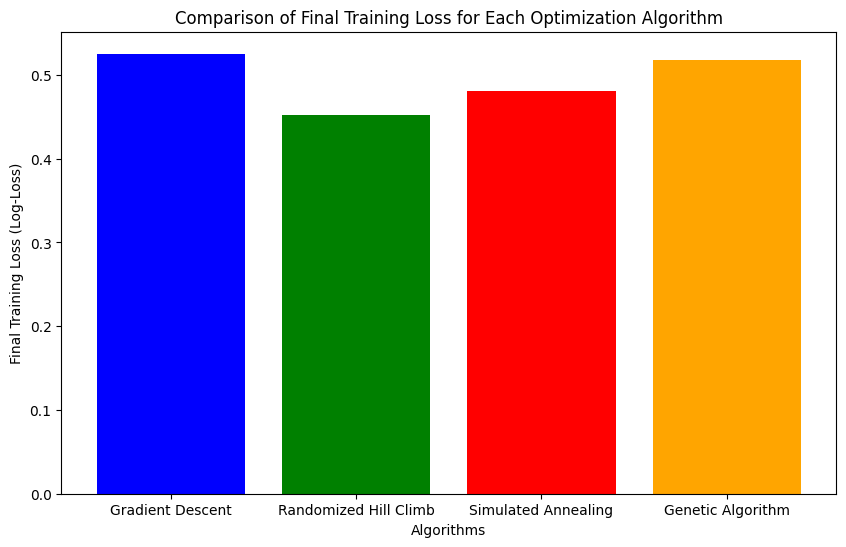


Execution Times (in seconds):
Gradient Descent: 73.9617 seconds
Randomized Hill Climb: 44.0729 seconds
Simulated Annealing: 39.8119 seconds
Genetic Algorithm: 1104.5106 seconds


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping
from torch import nn
from torch import optim
from pyperch.neural.backprop_nn import BackpropModule  # Import from pyperch
from pyperch.neural.rhc_nn import RHCModule  # Import RHCModule
from pyperch.neural.sa_nn import SAModule  # Import SAModule
from pyperch.neural.ga_nn import GAModule  # Import GAModule
import time  # For time tracking

# Set seed for reproducibility
seed = 4
torch.manual_seed(seed)
np.random.seed(seed)

# Assume diabetes dataset is already loaded as `diabetes` with `features` and `target` attributes.

# LabelEncode the outcome labels (diabetes)
Label = preprocessing.LabelEncoder()
diabetes_outcome = Label.fit_transform(diabetes.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(diabetes.features, diabetes_outcome, test_size=0.2, random_state=seed, shuffle=True)

# Scale features
scaler_diab = StandardScaler()
X_train = scaler_diab.fit_transform(X_train).astype(np.float32)  # Convert to float32
X_test = scaler_diab.transform(X_test).astype(np.float32)  # Convert to float32

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\nEvaluating {model_name} model...")

    # Training accuracy
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_acc:.4f}")

    # Test accuracy
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Confusion matrix and classification report
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("Classification report:")
    print(classification_report(y_test, y_test_pred))

    return model.history[-1, 'train_loss']  # Return the final training loss


### Collect Training Loss for Each Algorithm ###
final_losses = {}  # To store final losses for each algorithm
execution_times = {}  # To store execution times for each algorithm

### EarlyStopping Callback ###
early_stopping = EarlyStopping(patience=1000, monitor='valid_loss', lower_is_better=True)

### Gradient Descent Optimization ###
print("\nRunning Gradient Descent Optimization...")
start_time = time.time()  # Track start time
net_gd = NeuralNetClassifier(
    module=BackpropModule,
    module__layer_sizes=(8, 8, 2),  # Same layer sizes as in your MLPClassifier
    module__activation=nn.Sigmoid(),  # Use logistic (sigmoid) activation function
    max_epochs=5000,  # Set to more than the max_iter of 600 in MLPClassifier
    verbose=0,  # Suppress detailed training output
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True), early_stopping],  # Add Early Stopping
    criterion=nn.CrossEntropyLoss(),  # Use CrossEntropyLoss for classification
    optimizer=optim.Adam,  # Use the Adam optimizer (same as sklearn's MLPClassifier with 'adam' solver)
    lr=0.0001,  # Learning rate set to 0.0001
    iterator_train__shuffle=True  # Shuffle the training data on each epoch
)
net_gd.fit(X_train, y_train)  # Fit the model on the training data
execution_times['Gradient Descent'] = time.time() - start_time  # Record execution time

loss_gd = evaluate_model(net_gd, X_train, y_train, X_test, y_test, "Gradient Descent")
final_losses['Gradient Descent'] = loss_gd


### RHC Optimization ###
print("\nRunning Randomized Hill Climbing (RHC) Optimization...")
start_time = time.time()  # Track start time
net_rhc = NeuralNetClassifier(
    module=RHCModule,
    module__layer_sizes=(8, 8, 2),
    max_epochs=5000,  # More epochs for RHC
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True), early_stopping],  # Add Early Stopping
    iterator_train__shuffle=True,
)
net_rhc.fit(X_train, y_train)
execution_times['Randomized Hill Climb'] = time.time() - start_time  # Record execution time

loss_rhc = evaluate_model(net_rhc, X_train, y_train, X_test, y_test, "RHC")
final_losses['Randomized Hill Climb'] = loss_rhc


### SA Optimization ###
print("\nRunning Simulated Annealing (SA) Optimization...")
start_time = time.time()  # Track start time
net_sa = NeuralNetClassifier(
    module=SAModule,
    module__layer_sizes=(8, 8, 2),
    max_epochs=5000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True), early_stopping],  # Add Early Stopping
    module__t_min=0.001,  # Min temperature
    module__step_size=0.05,  # Step size for updates
    module__t=17500,  # Initial temperature
    module__cooling=0.995,  # Cooling rate
    iterator_train__shuffle=True
)
net_sa.fit(X_train, y_train)
execution_times['Simulated Annealing'] = time.time() - start_time  # Record execution time

loss_sa = evaluate_model(net_sa, X_train, y_train, X_test, y_test, "SA")
final_losses['Simulated Annealing'] = loss_sa


### GA Optimization ###
print("\nRunning Genetic Algorithm (GA) Optimization...")
start_time = time.time()  # Track start time
net_ga = NeuralNetClassifier(
    module=GAModule,
    module__layer_sizes=(8, 8, 2),
    max_epochs=500,  # Fewer epochs for GA
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True), early_stopping],  # Add Early Stopping
    criterion=nn.CrossEntropyLoss(),  # Use CrossEntropyLoss
    iterator_train__shuffle=True,
    module__population_size=300,  # Population size for GA
    module__to_mate=30,  # Number to mate per generation
    module__to_mutate=10,  # Number to mutate per generation
    module__dropout_percent=0.01,
    module__activation=nn.SELU()  # Use SELU activation
)
net_ga.fit(X_train, y_train)
execution_times['Genetic Algorithm'] = time.time() - start_time  # Record execution time

loss_ga = evaluate_model(net_ga, X_train, y_train, X_test, y_test, "GA")
final_losses['Genetic Algorithm'] = loss_ga


### Plot the Final Training Loss for Each Algorithm ###
plt.figure(figsize=(10, 6))

algorithms = final_losses.keys()
loss_values = final_losses.values()

# Create a bar chart to visualize the final loss for each algorithm
plt.bar(algorithms, loss_values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel("Algorithms")
plt.ylabel("Final Training Loss (Log-Loss)")
plt.title("Comparison of Final Training Loss for Each Optimization Algorithm")
plt.show()

### Print Execution Times for Each Algorithm ###
print("\nExecution Times (in seconds):")
for algo, exec_time in execution_times.items():
    print(f"{algo}: {exec_time:.4f} seconds")


#### Learning curve: iteration vs loss

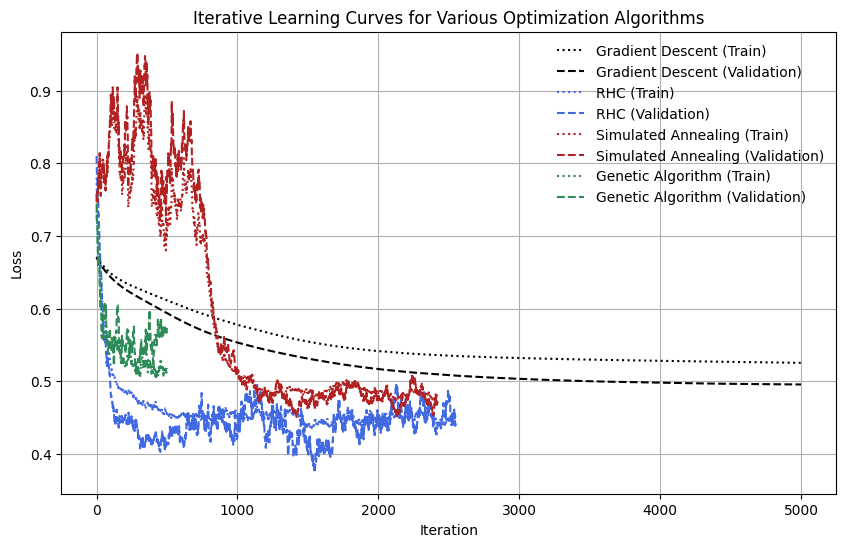

In [ ]:
# -- Iterative learning curve: iteration vs loss --
import matplotlib.pyplot as plt

# Function to plot learning curves
def plot_learning_curves(algorithms, history_dict):
    plt.figure(figsize=(10, 6))

    # Gradient Descent (Standard NN Implementation) - Black
    plt.plot(history_dict['Gradient Descent'][:, 'train_loss'], label='Gradient Descent (Train)', linestyle=':', color='black')
    plt.plot(history_dict['Gradient Descent'][:, 'valid_loss'], label='Gradient Descent (Validation)', linestyle='--', color='black')

    # RHC - Royal Blue
    plt.plot(history_dict['RHC'][:, 'train_loss'], label='RHC (Train)', linestyle=':', color='royalblue')
    plt.plot(history_dict['RHC'][:, 'valid_loss'], label='RHC (Validation)', linestyle='--', color='royalblue')

    # Simulated Annealing - Firebrick
    plt.plot(history_dict['SA'][:, 'train_loss'], label='Simulated Annealing (Train)', linestyle=':', color='firebrick')
    plt.plot(history_dict['SA'][:, 'valid_loss'], label='Simulated Annealing (Validation)', linestyle='--', color='firebrick')

    # Genetic Algorithm - Seagreen
    plt.plot(history_dict['GA'][:, 'train_loss'], label='Genetic Algorithm (Train)', linestyle=':', color='seagreen')
    plt.plot(history_dict['GA'][:, 'valid_loss'], label='Genetic Algorithm (Validation)', linestyle='--', color='seagreen')

    # Plot settings
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Iterative Learning Curves for Various Optimization Algorithms")
    plt.grid(visible=True)
    plt.legend(frameon=False)
    plt.show()

# Assuming you have the net history from each algorithm stored in a dictionary
history_dict = {
    'Gradient Descent': net_gd.history,  # Replace with the actual history of Gradient Descent
    'RHC': net_rhc.history,              # Replace with the actual history of Randomized Hill Climb
    'SA': net_sa.history,                # Replace with the actual history of Simulated Annealing
    'GA': net_ga.history                 # Replace with the actual history of Genetic Algorithm
}

# Call the function to plot the learning curves
plot_learning_curves(['Gradient Descent', 'RHC', 'SA', 'GA'], history_dict)


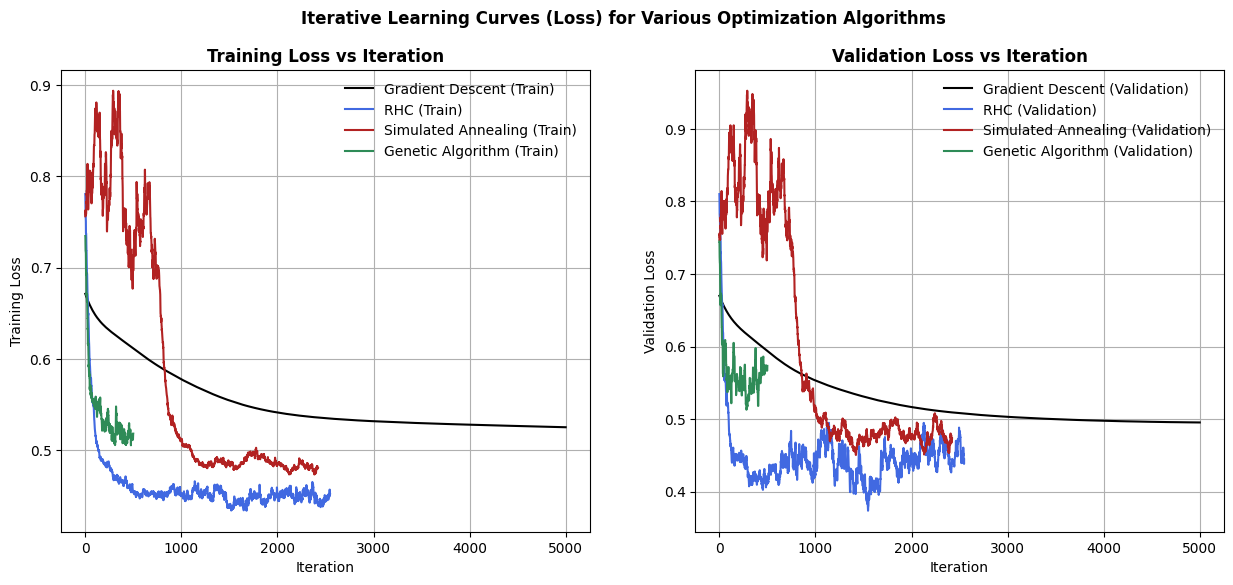

In [ ]:
import matplotlib.pyplot as plt

# Function to plot learning curves (Train and Validation separately)
def plot_learning_curves(algorithms, history_dict):
    fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(15, 6))  # Create two subplots horizontally

    # Training Loss Plot (Left)
    ax_train.plot(history_dict['Gradient Descent'][:, 'train_loss'], label='Gradient Descent (Train)', linestyle='-', color='black')
    ax_train.plot(history_dict['RHC'][:, 'train_loss'], label='RHC (Train)', linestyle='-', color='royalblue')
    ax_train.plot(history_dict['SA'][:, 'train_loss'], label='Simulated Annealing (Train)', linestyle='-', color='firebrick')
    ax_train.plot(history_dict['GA'][:, 'train_loss'], label='Genetic Algorithm (Train)', linestyle='-', color='seagreen')
    ax_train.set_xlabel("Iteration")
    ax_train.set_ylabel("Training Loss")
    ax_train.set_title("Training Loss vs Iteration", fontweight='bold')  # Title in bold
    ax_train.grid(visible=True)
    ax_train.legend(frameon=False)

    # Validation Loss Plot (Right)
    ax_val.plot(history_dict['Gradient Descent'][:, 'valid_loss'], label='Gradient Descent (Validation)', linestyle='-', color='black')
    ax_val.plot(history_dict['RHC'][:, 'valid_loss'], label='RHC (Validation)', linestyle='-', color='royalblue')
    ax_val.plot(history_dict['SA'][:, 'valid_loss'], label='Simulated Annealing (Validation)', linestyle='-', color='firebrick')
    ax_val.plot(history_dict['GA'][:, 'valid_loss'], label='Genetic Algorithm (Validation)', linestyle='-', color='seagreen')
    ax_val.set_xlabel("Iteration")
    ax_val.set_ylabel("Validation Loss")
    ax_val.set_title("Validation Loss vs Iteration", fontweight='bold')  # Title in bold
    ax_val.grid(visible=True)
    ax_val.legend(frameon=False)

    plt.suptitle("Iterative Learning Curves (Loss) for Various Optimization Algorithms", fontweight='bold')  # Main title in bold
    plt.show()

# Assuming you have the net history from each algorithm stored in a dictionary
history_dict = {
    'Gradient Descent': net_gd.history,  # Replace with the actual history of Gradient Descent
    'RHC': net_rhc.history,              # Replace with the actual history of Randomized Hill Climb
    'SA': net_sa.history,                # Replace with the actual history of Simulated Annealing
    'GA': net_ga.history                 # Replace with the actual history of Genetic Algorithm
}

# Call the function to plot the learning curves
plot_learning_curves(['Gradient Descent', 'RHC', 'SA', 'GA'], history_dict)


#### Learning curve: iteration vs accuracy

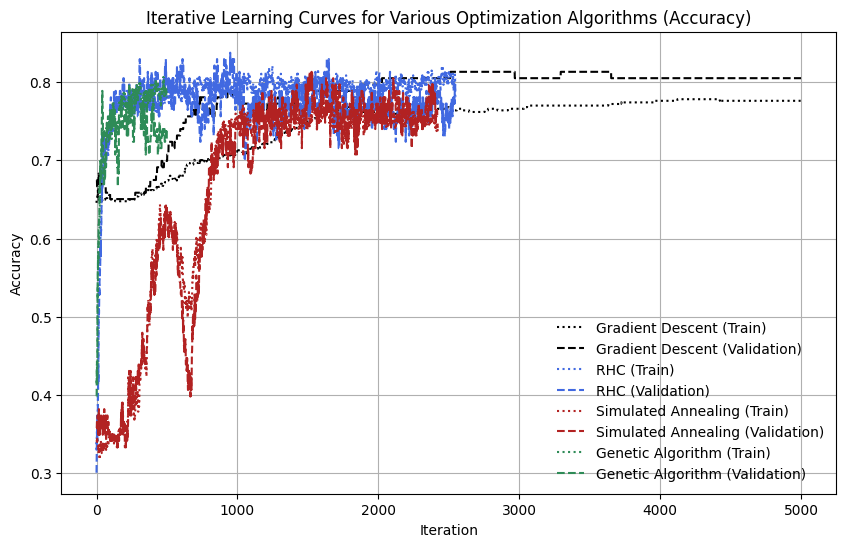

In [ ]:
import matplotlib.pyplot as plt

# Function to plot learning curves (Accuracy)
def plot_accuracy_curves(algorithms, history_dict):
    plt.figure(figsize=(10, 6))

    # Gradient Descent (Standard NN Implementation) - Black
    plt.plot(history_dict['Gradient Descent'][:, 'train_acc'], label='Gradient Descent (Train)', linestyle=':', color='black')
    plt.plot(history_dict['Gradient Descent'][:, 'valid_acc'], label='Gradient Descent (Validation)', linestyle='--', color='black')

    # RHC - Royal Blue
    plt.plot(history_dict['RHC'][:, 'train_acc'], label='RHC (Train)', linestyle=':', color='royalblue')
    plt.plot(history_dict['RHC'][:, 'valid_acc'], label='RHC (Validation)', linestyle='--', color='royalblue')

    # Simulated Annealing - Firebrick
    plt.plot(history_dict['SA'][:, 'train_acc'], label='Simulated Annealing (Train)', linestyle=':', color='firebrick')
    plt.plot(history_dict['SA'][:, 'valid_acc'], label='Simulated Annealing (Validation)', linestyle='--', color='firebrick')

    # Genetic Algorithm - Seagreen
    plt.plot(history_dict['GA'][:, 'train_acc'], label='Genetic Algorithm (Train)', linestyle=':', color='seagreen')
    plt.plot(history_dict['GA'][:, 'valid_acc'], label='Genetic Algorithm (Validation)', linestyle='--', color='seagreen')

    # Plot settings
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Iterative Learning Curves for Various Optimization Algorithms (Accuracy)")
    plt.grid(visible=True)
    plt.legend(frameon=False)
    plt.show()

# Assuming you have the net history from each algorithm stored in a dictionary
history_dict = {
    'Gradient Descent': net_gd.history,  # Replace with the actual history of Gradient Descent
    'RHC': net_rhc.history,              # Replace with the actual history of Randomized Hill Climb
    'SA': net_sa.history,                # Replace with the actual history of Simulated Annealing
    'GA': net_ga.history                 # Replace with the actual history of Genetic Algorithm
}

# Call the function to plot the accuracy learning curves
plot_accuracy_curves(['Gradient Descent', 'RHC', 'SA', 'GA'], history_dict)


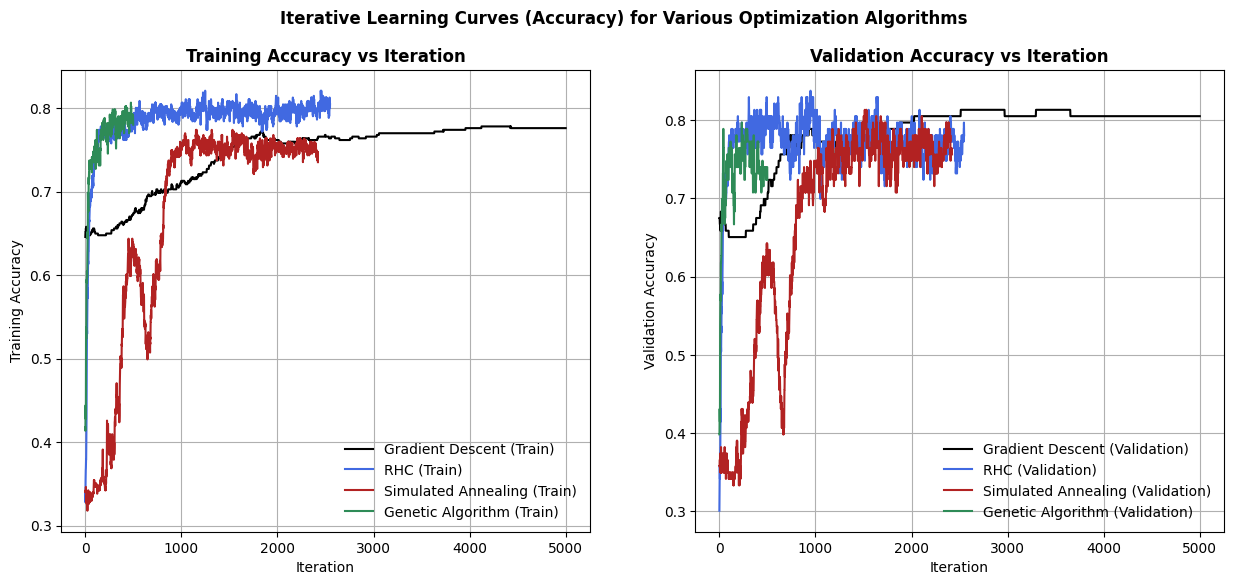

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy learning curves (Train and Validation separately)
def plot_accuracy_curves(algorithms, history_dict):
    fig, (ax_train, ax_val) = plt.subplots(1, 2, figsize=(15, 6))  # Create two subplots horizontally

    # Training Accuracy Plot (Left)
    ax_train.plot(history_dict['Gradient Descent'][:, 'train_acc'], label='Gradient Descent (Train)', linestyle='-', color='black')
    ax_train.plot(history_dict['RHC'][:, 'train_acc'], label='RHC (Train)', linestyle='-', color='royalblue')
    ax_train.plot(history_dict['SA'][:, 'train_acc'], label='Simulated Annealing (Train)', linestyle='-', color='firebrick')
    ax_train.plot(history_dict['GA'][:, 'train_acc'], label='Genetic Algorithm (Train)', linestyle='-', color='seagreen')
    ax_train.set_xlabel("Iteration")
    ax_train.set_ylabel("Training Accuracy")
    ax_train.set_title("Training Accuracy vs Iteration", fontweight='bold')  # Title in bold
    ax_train.grid(visible=True)
    ax_train.legend(frameon=False)

    # Validation Accuracy Plot (Right)
    ax_val.plot(history_dict['Gradient Descent'][:, 'valid_acc'], label='Gradient Descent (Validation)', linestyle='-', color='black')
    ax_val.plot(history_dict['RHC'][:, 'valid_acc'], label='RHC (Validation)', linestyle='-', color='royalblue')
    ax_val.plot(history_dict['SA'][:, 'valid_acc'], label='Simulated Annealing (Validation)', linestyle='-', color='firebrick')
    ax_val.plot(history_dict['GA'][:, 'valid_acc'], label='Genetic Algorithm (Validation)', linestyle='-', color='seagreen')
    ax_val.set_xlabel("Iteration")
    ax_val.set_ylabel("Validation Accuracy")
    ax_val.set_title("Validation Accuracy vs Iteration", fontweight='bold')  # Title in bold
    ax_val.grid(visible=True)
    ax_val.legend(frameon=False)

    plt.suptitle("Iterative Learning Curves (Accuracy) for Various Optimization Algorithms", fontweight='bold')  # Main title in bold
    plt.show()

# Assuming you have the net history from each algorithm stored in a dictionary
history_dict = {
    'Gradient Descent': net_gd.history,  # Replace with the actual history of Gradient Descent
    'RHC': net_rhc.history,              # Replace with the actual history of Randomized Hill Climb
    'SA': net_sa.history,                # Replace with the actual history of Simulated Annealing
    'GA': net_ga.history                 # Replace with the actual history of Genetic Algorithm
}

# Call the function to plot the accuracy learning curves
plot_accuracy_curves(['Gradient Descent', 'RHC', 'SA', 'GA'], history_dict)


#### Implementation with mlrose-hiive (for reference only)

Backpropagation vs RO algorithms in Neural Networks (mlrose-hiive)


Running Gradient Descent Optimization...

Evaluating Gradient Descent model...
Training Accuracy: 0.7899
Test Accuracy: 0.7727
Confusion matrix:
[[81 21]
 [14 38]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       102
           1       0.64      0.73      0.68        52

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.78       154


Running Randomized Hill Climbing (RHC) Optimization...

Evaluating RHC model...
Training Accuracy: 0.6352
Test Accuracy: 0.6558
Confusion matrix:
[[60 42]
 [11 41]]
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.59      0.69       102
           1       0.49      0.79      0.61        52

    accuracy                           0.66       154
   macro avg       0.67      0.69      0.65       154
weighted avg       0.73 

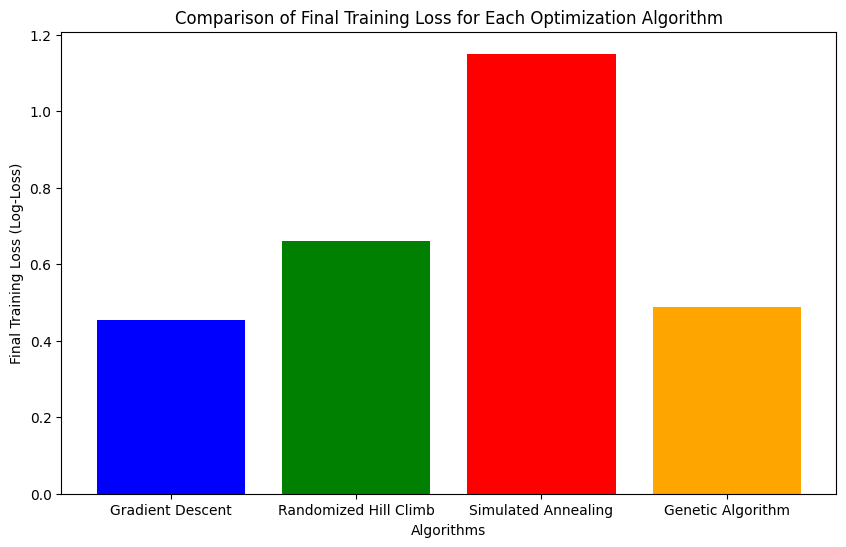

In [ ]:
import mlrose_hiive as mlrose
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set seed for reproducibility
seed = 4

# LabelEncode the outcome labels (diabetes)
Label = preprocessing.LabelEncoder()
diabetes_outcome = Label.fit_transform(diabetes.target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(diabetes.features, diabetes_outcome, test_size=0.2, random_state=seed, shuffle=True)

# Scale features
scaler_diab = StandardScaler()
X_train = scaler_diab.fit_transform(X_train)
X_test = scaler_diab.transform(X_test)

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\nEvaluating {model_name} model...")

    # Training accuracy
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f"Training Accuracy: {train_acc:.4f}")

    # Test accuracy
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Confusion matrix and classification report
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("Classification report:")
    print(classification_report(y_test, y_test_pred))

    return model.loss  # Return the final loss


### Collect Training Loss for Each Algorithm ###
final_losses = {}  # To store final losses for each algorithm

### Gradient Descent Optimization ###
print("\nRunning Gradient Descent Optimization...")
nn_model_gd = mlrose.NeuralNetwork(
    hidden_nodes=[8, 8],  # Same structure as your MLPClassifier
    activation='tanh',
    algorithm='gradient_descent',  # Set to Gradient Descent
    max_iters=1000,  # Maximum iterations for optimization
    bias=True,  # Include bias term
    learning_rate=0.0001,  # Learning rate
    early_stopping=True,  # Use early stopping
    clip_max=5,  # Max value for weight clipping
    max_attempts=100,  # Max attempts for early stopping
    random_state=seed,
    curve=True  # Return learning curve
)
nn_model_gd.fit(X_train, y_train)
# fitness_curve_gd = nn_model_gd.fitness_curve  # Get the fitness curve
# print("Fitness curve: ", fitness_curve_gd)
loss_gd = evaluate_model(nn_model_gd, X_train, y_train, X_test, y_test, "Gradient Descent")
final_losses['Gradient Descent'] = loss_gd


### RHC Optimization ###
print("\nRunning Randomized Hill Climbing (RHC) Optimization...")
nn_model_rhc = mlrose.NeuralNetwork(
    hidden_nodes=[8, 8],  # Same structure as your MLPClassifier
    activation='tanh',
    algorithm='random_hill_climb',  # Set to RHC
    max_iters=1000,  # Maximum iterations for optimization
    bias=True,  # Include bias term
    learning_rate=0.001,  # Learning rate
    early_stopping=True,  # Use early stopping
    clip_max=5,  # Max value for weight clipping
    restarts=20,  # Number of restarts
    max_attempts=100,  # Max attempts for early stopping
    random_state=seed,
    curve=True  # Return learning curve
)
nn_model_rhc.fit(X_train, y_train)
loss_rhc = evaluate_model(nn_model_rhc, X_train, y_train, X_test, y_test, "RHC")
final_losses['Randomized Hill Climb'] = loss_rhc


### SA Optimization ###
print("\nRunning Simulated Annealing (SA) Optimization...")
nn_model_sa = mlrose.NeuralNetwork(
    hidden_nodes=[8, 8],
    activation='tanh',
    algorithm='simulated_annealing',  # Set to SA
    max_iters=1000,
    bias=True,
    learning_rate=0.001,
    early_stopping=True,
    clip_max=5,
    max_attempts=100,
    schedule=mlrose.ExpDecay(init_temp=100),
    random_state=seed,
    curve=True
)
nn_model_sa.fit(X_train, y_train)
loss_sa = evaluate_model(nn_model_sa, X_train, y_train, X_test, y_test, "SA")
final_losses['Simulated Annealing'] = loss_sa


### GA Optimization ###
print("\nRunning Genetic Algorithm (GA) Optimization...")
nn_model_ga = mlrose.NeuralNetwork(
    hidden_nodes=[8, 8],
    activation='tanh',
    algorithm='genetic_alg',
    max_iters=1000,
    bias=True,
    learning_rate=0.001,
    early_stopping=True,
    clip_max=5,
    max_attempts=100,
    pop_size=100,
    mutation_prob=0.1,
    random_state=seed,
    curve=True
)
nn_model_ga.fit(X_train, y_train)
loss_ga = evaluate_model(nn_model_ga, X_train, y_train, X_test, y_test, "GA")
final_losses['Genetic Algorithm'] = loss_ga


### Plot the Final Training Loss for Each Algorithm ###
plt.figure(figsize=(10, 6))

algorithms = final_losses.keys()
loss_values = final_losses.values()

# Create a bar chart to visualize the final loss for each algorithm
plt.bar(algorithms, loss_values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel("Algorithms")
plt.ylabel("Final Training Loss (Log-Loss)")
plt.title("Comparison of Final Training Loss for Each Optimization Algorithm")
plt.show()


### **Reference: Neural Networks (NN) for Diabetes Dataset**

In [ ]:
from sklearn import preprocessing

# LabelEncoder is used to encode categorical labels (strings or numbers) into numerical values, specifically integers.
# This is useful in ML when you have categorical data that you need to convert to a numerical format, since ML algorithms require numerical input.
Label = preprocessing.LabelEncoder()

diabetes_outcome = Label.fit_transform(diabetes.target)
# print(diabetes_outcome)     # Categorical variable is converted to numerical variable

In [ ]:
# Split dataset in training dataset and test dataset.
# Training dataset: it is used to train and tune hyperparameters in model.
# Test dataset: it is used at the end once model is ready.
X_train, X_test, y_train, y_test = train_test_split(diabetes.features, diabetes_outcome, test_size = 0.2, random_state=sklearn_random_state, shuffle = True)  # 20% of data for testing purposes. Random_state for reproducible output. Shuffle data before splitting
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [ ]:
# Scale features is recommended in ML models
from sklearn.preprocessing import StandardScaler
scaler_diab = StandardScaler()
scaler_diab.fit(X_train)                       # Fit the scaler on the training data (compute mean and std). This means it calculates the mean and standard deviation of each feature in the X_train dataset.
X_train = scaler_diab.fit_transform(X_train)   # Transform the training data
X_test = scaler_diab.transform(X_test)         # Transform the test data using the same scaler. This ensures that X_test is scaled using the mean and standard deviation calculated from the X_train dataset. Both X_train and X_test are scaled consistently.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

# Initialize MLPClassifier
MLP = MLPClassifier(activation = 'logistic', hidden_layer_sizes = (8,8), solver = 'adam', alpha = 0.0001, max_iter = 600, random_state=sklearn_random_state)

# Perform cross-validation on the training data to evaluate performance of model
# Split the training data in k-fold, such as each fold takes a turn to be a validation set
cv_scores = cross_val_score(MLP, X_train, y_train, cv=5)      # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")                # Default estimator's scoring is used. For NN, it is accuracy
print(f"Average cross-validation score: {cv_scores.mean()}")

# Perform cross-validated predictions in X_train to assess how well the model generalizes to unseen data
y_train_pred = cross_val_predict(MLP, X_train, y_train, cv=5)

# Evaluate the model using cross-validated predictions on the training set
print("\nCross-validated training set evaluation:")
print("Confusion matrix: ")
print(confusion_matrix(y_train, y_train_pred))
print("Classification report: ")
print(classification_report(y_train, y_train_pred, zero_division = np.nan))
print("Accuracy score between y_train and y_train_pred: ")
print(accuracy_score(y_train, y_train_pred))

Cross-validation scores: [0.78861789 0.80487805 0.78861789 0.71544715 0.7704918 ]
Average cross-validation score: 0.7736105557776888

Cross-validated training set evaluation:
Confusion matrix: 
[[346  52]
 [ 87 129]]
Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       398
           1       0.71      0.60      0.65       216

    accuracy                           0.77       614
   macro avg       0.76      0.73      0.74       614
weighted avg       0.77      0.77      0.77       614

Accuracy score between y_train and y_train_pred: 
0.7736156351791531


In [ ]:
# Train the model on the entire training data
# Hyperparameters have been already tuned using cross validation
start_time = time.time()
MLP.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.4f} seconds")

# Print the number of iterations used to train the model
print("Number of iterations:")
print(MLP.n_iter_)

# Ensure that the model has been trained before accessing coefs_
if hasattr(MLP, 'coefs_'):
    # Extract and print the weights and biases of the model
    print("Model Weights:")
    for i, layer_weights in enumerate(MLP.coefs_):
        print(f"Layer {i+1} weights shape: {layer_weights.shape}")
        print(layer_weights)

    print("Model Biases:")
    for i, layer_biases in enumerate(MLP.intercepts_):
        print(f"Layer {i+1} biases shape: {layer_biases.shape}")
        print(layer_biases)
else:
    print("The model has not been trained yet or did not converge properly.")

# Evaluate the model by predicting values on the test dataset
query_start_time = time.time()
y_test_pred = MLP.predict(X_test)
query_time = time.time() - query_start_time
print(f"Query time (prediction time): {query_time:.4f} seconds")

print("y_test_pred: ")
print(y_test_pred)

# Compare to actual values in test dataset
print("y_test: ")
print(y_test)

from sklearn.metrics import classification_report, confusion_matrix
print("Test set evaluation:")
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_test_pred))
print("Classification report: ")
print(classification_report(y_test, y_test_pred, zero_division = np.nan))
print("Accuracy score between y_test and y_test_pred: ")
print(accuracy_score(y_test, y_test_pred))

Training time: 0.7612 seconds
Number of iterations:
425
Model Weights:
Layer 1 weights shape: (8, 8)
[[-0.0762723  -0.23151824  0.81229781 -0.19187014  0.63428997 -0.77975707
  -0.01175429 -0.55133953]
 [-1.23098951 -1.00607115  1.08660568 -1.08093839  1.10286296 -0.60198235
  -1.21489738 -0.81695222]
 [-0.00249592  0.08603961 -0.50192376  0.31262935 -0.35770602  0.46875861
   0.30735631  0.30258528]
 [-0.05179783 -0.20144982 -0.24950958 -0.0417107  -0.18520183  0.22914831
   0.1000186   0.16018415]
 [-0.32725907 -0.2897351  -0.29072584 -0.10727397 -0.250464    0.15601423
  -0.20010361 -0.16065537]
 [-1.04356896 -0.87266441  0.75491853 -1.08297789  0.46387463 -0.71872711
  -0.8313795  -0.97597408]
 [-0.60055791 -0.46618234  0.52591735 -0.51083611  0.40694262 -0.54092314
  -0.56628965 -0.60843532]
 [ 0.35842302  0.17265224  0.86905758 -0.03377181  0.89922639 -0.85105666
  -0.11494666  0.16401555]]
Layer 2 weights shape: (8, 8)
[[-0.46257731  0.74512804  0.14882092  0.53154291 -0.7965938

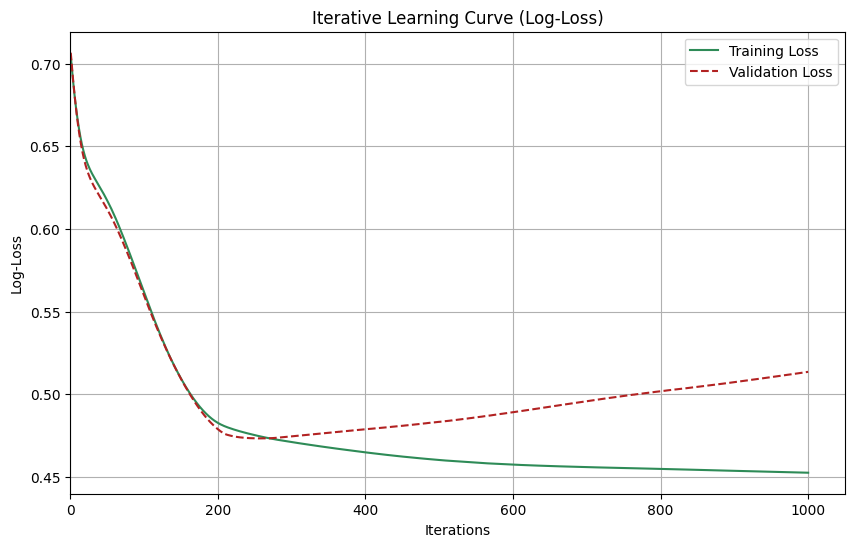

In [ ]:
# -- Iterative learning curve: iteration vs loss --

# Iterative learning curve shows how the loss changes over multiple iterations
# during training for both the training data and validation data.

# Per ChatGPT explanation:
# Scikit-learn's MLPClassifier provides a loss_curve_ attribute after training, which records the loss at each iteration.
# We'll use this attribute to plot the loss over iterations for both training and validation datasets.
# Re-initialize the MLPClassifier with necessary parameters
mlp_logloss = MLPClassifier(
    activation='logistic',
    hidden_layer_sizes=(8,8),
    solver = 'adam', alpha = 0.0001,
    max_iter=1,  # One iteration (or epoch) of training will be done in each call of the fit() method. We will control number of iterations manually.
    warm_start=True,  # This allows the model to continue training from where it left off in the previous call to fit(). Without this, each call to fit() would restart the training from scratch.
    random_state = sklearn_random_state
)

# Lists to store log loss (cross-entropy loss) values for each iteration
train_loss = [] # For training set
val_loss = []   # For validation set

# Number of iterations
n_iterations = 1000

# Suppress the ConvergenceWarning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for i in range(n_iterations):
    mlp_logloss.fit(X_train, y_train)

    # Predict probabilities for each class. This is done for train and validation sets
    y_train_prob = mlp_logloss.predict_proba(X_train)
    # print("y_train_prob: ", y_train_prob)
    y_val_prob = mlp_logloss.predict_proba(X_test)
    # print("y_val_prob: ", y_val_prob)


    # Compute log loss (cross-entropy loss) for train and validation sets.
    # Log loss measures how well the model's predicted probabilities match the true class labels
    train_loss.append(log_loss(y_train, y_train_prob))
    val_loss.append(log_loss(y_test, y_val_prob))

# # Seee log loss values
# print("train_loss: ", train_loss)
# print("val_loss: ", val_loss)

# Plotting
plt.figure(figsize=(10, 6))
# Plotting training and validation loss
plt.plot(range(1, n_iterations + 1), train_loss, label='Training Loss', color='seagreen')
plt.plot(range(1, n_iterations + 1), val_loss, label='Validation Loss', color = 'firebrick', linestyle = "--")
# Set axis limits: Ensure x and y axes start from zero
plt.xlim(left=0)  # x-axis starting at 0
# plt.ylim(bottom=0, top = 1)  # y-axis starting at 0
# plt.ylim(bottom=0)  # y-axis starting at 0
# Labels and title
plt.xlabel('Iterations')
plt.ylabel('Log-Loss')
plt.title('Iterative Learning Curve (Log-Loss)')
# Show legend and grid
plt.legend()
plt.grid(True)
plt.show()

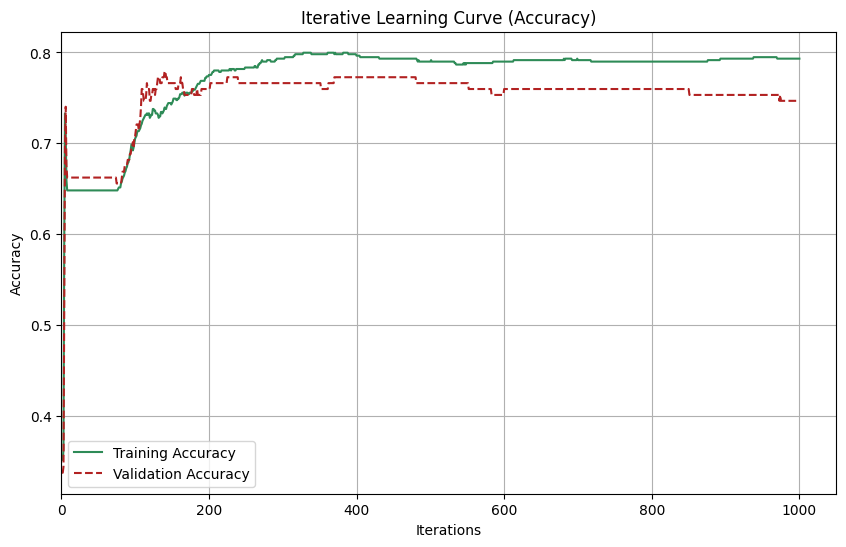

In [ ]:
# -- Iterative learning curve: iteration vs accuracy --

# Iterative learning curve shows how the accuracy changes over multiple iterations
# The goal is to observe how the model's performance improves (or not) over time.

# Per ChatGPT explanation:
# Similar to loss, we can track accuracy over iterations by evaluating the model's predictions after each incremental training step.
# We'll record accuracy on both training and validation datasets at each iteration.
# Re-initialize the MLPClassifier with necessary parameters
mlp_accuracy = MLPClassifier(
    activation='logistic',
    hidden_layer_sizes=(8,8),
    solver = 'adam', alpha = 0.0001,
    max_iter=1,  # One iteration (or epoch) of training will be done in each call of the fit() method. We will control number of iterations manually.
    warm_start=True,  # This allows the model to continue training from where it left off in the previous call to fit(). Without this, each call to fit() would restart the training from scratch.
    random_state = sklearn_random_state
)

# Lists to store accuracy values
train_accuracy = [] # For training set
val_accuracy = []   # For validation set

# Number of iterations
n_iterations = 1000

# Suppress the ConvergenceWarning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for i in range(n_iterations):
    mlp_accuracy.fit(X_train, y_train)

    # Predict on train and validation sets
    y_train_pred = mlp_accuracy.predict(X_train)
    y_val_pred = mlp_accuracy.predict(X_test)

    # Compute accuracy for train and validation sets
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    val_accuracy.append(accuracy_score(y_test, y_val_pred))

# Plotting
plt.figure(figsize=(10, 6))
# Plotting training and validation accuracy
plt.plot(range(1, n_iterations + 1), train_accuracy, label='Training Accuracy', color='seagreen')
plt.plot(range(1, n_iterations + 1), val_accuracy, label='Validation Accuracy', color='firebrick', linestyle = "--")
# Set axis limits: Ensure x and y axes start from zero
plt.xlim(left=0)  # x-axis starting at 0
# plt.ylim(bottom=0)  # y-axis starting at 0
# Labels and title
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Iterative Learning Curve (Accuracy)')
# Show legend and grid
plt.legend()
plt.grid(True)
plt.show()
